                  transformation  count
0                  "input_shape"   3232
1                   "repetition"   3232
2       "pattern_uniform_blocks"   3232
3     "pattern_vertical_stripes"   3232
4   "pattern_horizontal_stripes"   3232
5         "pattern_checkerboard"   3232
6              "partial_symetry"   3232
7                "tiled_subgrid"   3232
8                  "translation"   3232
9                      "padding"   3232
10                   "transpose"   3232
11                "output_shape"   3232
12               "flip_vertical"   3232
13             "flip_horizontal"   3232
14                "rotation_270"   3232
15                "rotation_180"   3232
16                 "rotation_90"   3232
17                "recoloration"   3232
18               "output_colors"   3232
19                "input_colors"   3232
20    "shape_based_recoloration"   3232


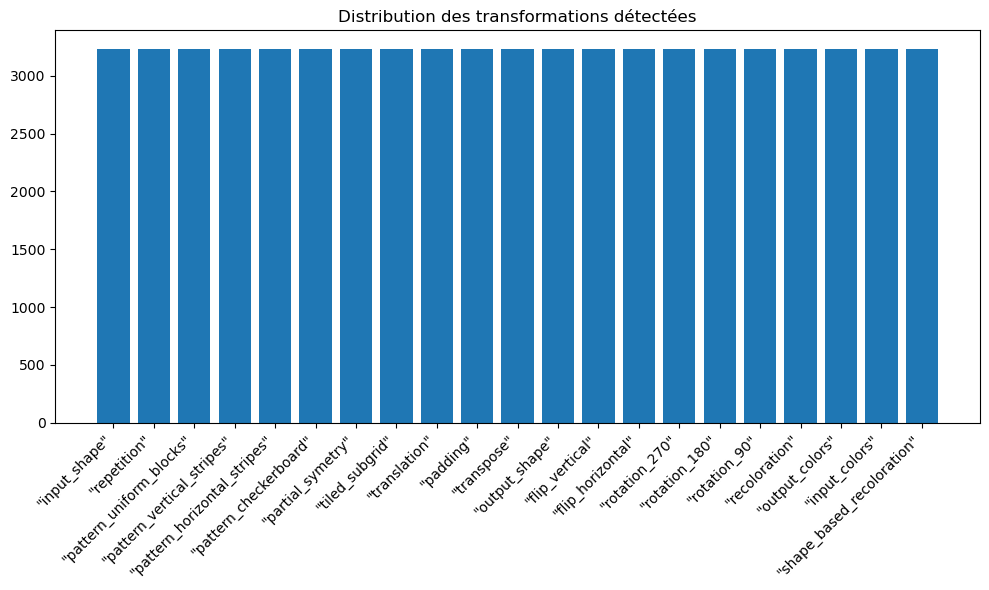

Résumé exporté dans summary_transformations.csv


In [3]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Chargement
with open('../data/detected_transformations.json', 'r', encoding='utf-8') as f:
    detected = json.load(f)

# 2) Aplati toutes les transformations
all_types = []
for task_id, transformations in detected.items():
    for entry in transformations:
        # entry est typiquement un dict {'pair_id':…, 'transformations': […]}
        for t in entry.get('transformations', []):
            if isinstance(t, dict) and 'type' in t:
                all_types.append(t['type'])
            else:
                # fallback : stringify la transformation
                all_types.append(json.dumps(t, sort_keys=True))

# 3) Compte
counter = Counter(all_types)
df_counts = (
    pd.DataFrame(counter.items(), columns=['transformation', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

print(df_counts)

# 4) Tracer
plt.figure(figsize=(10,6))
plt.bar(df_counts['transformation'], df_counts['count'])
plt.xticks(rotation=45, ha='right')
plt.title("Distribution des transformations détectées")
plt.tight_layout()
plt.show()

# 5) Exporte
df_counts.to_csv('summary_transformations.csv', index=False)
print("Résumé exporté dans summary_transformations.csv")


In [4]:
import json
import pandas as pd
import csv  # pour le paramètre quoting

# 1) Chargement
with open('../data/detected_transformations.json', 'r', encoding='utf-8') as f:
    detected = json.load(f)

# 2) Construction des lignes
rows = []
for task_id, pairs in detected.items():
    for pair in pairs:
        row = {
            "task_id": task_id,
            "pair_id": pair["pair_id"]
        }
        # Conversion explicite des listes en chaînes pour éviter confusion avec les virgules
        for k, v in pair["transformations"].items():
            if isinstance(v, list):
                row[k] = str(v)  # str([1,2]) = '[1, 2]'
            else:
                row[k] = v
        rows.append(row)

# 3) DataFrame
df = pd.DataFrame(rows)

# 4) Export CSV avec guillemets pour les non numériques
df.to_csv("detailed_transformations.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)
print("Export terminé dans detailed_transformations.csv avec séparateurs corrects.")


Export terminé dans detailed_transformations.csv avec séparateurs corrects.


In [5]:
df.head()

,task_id,pair_id,input_shape,output_shape,input_colors,output_colors,recoloration,rotation_90,rotation_180,rotation_270,...,repetition,padding,translation,tiled_subgrid,partial_symetry,pattern_checkerboard,pattern_horizontal_stripes,pattern_vertical_stripes,pattern_uniform_blocks,shape_based_recoloration
0,00576224,0,"[2, 2]","[6, 6]","[3, 4, 7, 9]","[3, 4, 7, 9]",False,False,False,False,...,False,True,True,False,None,False,True,True,False,False
1,00576224,1,"[2, 2]","[6, 6]","[4, 6, 8]","[4, 6, 8]",False,False,False,False,...,False,True,True,False,None,False,True,True,False,False
2,007bbfb7,0,"[3, 3]","[9, 9]","[0, 6]","[0, 6]",False,False,False,False,...,False,True,True,False,None,False,False,False,False,False
3,007bbfb7,1,"[3, 3]","[9, 9]","[0, 4]","[0, 4]",False,False,False,False,...,False,True,True,False,None,False,False,False,False,False
4,007bbfb7,2,"[3, 3]","[9, 9]","[0, 2]","[0, 2]",False,False,False,False,...,False,True,True,False,None,False,False,False,False,False


In [ ]:
import numpy as np

# Construction d'un dataset supervisé
# Chargement des fichiers
with open("../data/arc-agi_training_challenges.json") as f:
    challenges = json.load(f) # training_data dans le notebook du concours

with open("../data/arc-agi_training_solutions.json") as f:
    solutions = json.load(f) # training_solutions dans le notebook du concours

X_data = []
y_data = []
task_ids = []

# Pour chaque tâche
for task_id, task_content in challenges.items():
    test_inputs = task_content.get("test", [])
    test_solutions = solutions.get(task_id, [])

    for i, test_input in enumerate(test_inputs):
        try:
            input_grid = np.array(test_input["input"])
            output_grid = np.array(test_solutions[i])
            X_data.append(input_grid)
            y_data.append(output_grid)
            task_ids.append(task_id)
        except IndexError:
            print(f"Pas de solution pour la tâche {task_id} - test {i}")

In [7]:
import torch
import torch.nn.functional as F

def to_tensor_onehot_padded(data_list, num_classes=10):
    max_h = max([len(g) for g in data_list])
    max_w = max([len(g[0]) for g in data_list])

    tensors = []
    for grid in data_list:
        h, w = len(grid), len(grid[0])
        arr = torch.tensor(grid, dtype=torch.long)
        onehot = F.one_hot(arr, num_classes=num_classes)  # H x W x C
        onehot = onehot.permute(2, 0, 1).float()           # C x H x W

        # Padding to max_h x max_w
        pad_h = max_h - h
        pad_w = max_w - w
        onehot = F.pad(onehot, (0, pad_w, 0, pad_h), value=0)  # pad=(left, right, top, bottom)
        tensors.append(onehot)

    return torch.stack(tensors)  # N x C x H x W



In [8]:
X_tensor = to_tensor_onehot_padded(X_data, num_classes=10)
Y_tensor = to_tensor_onehot_padded(y_data, num_classes=10)
print(X_tensor.shape, Y_tensor.shape)

torch.Size([1076, 10, 30, 30]) torch.Size([1076, 10, 30, 30])


In [9]:
import torch.nn as nn

class ARCConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_classes, 32, kernel_size=3, padding=1),  # 10 → 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)  # 32 → 10 (classe par pixel)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # logits shape: [batch, 10, 30, 30]


In [10]:
import torch
print(torch.__version__)

2.7.1+cpu


In [11]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Dataset et DataLoader
dataset = TensorDataset(X_tensor, Y_tensor.argmax(dim=1))  # convertir one-hot → label par pixel
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Modèle, optimiseur, perte
model = ARCConvNet()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entraînement
train_losses = []

for epoch in range(40):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)  # shape: [B, 10, 30, 30]
        loss = criterion(output, batch_y)  # batch_y: [B, 30, 30]
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")




Epoch 1, Loss: 1.3843
Epoch 2, Loss: 0.4767
Epoch 3, Loss: 0.4431
Epoch 4, Loss: 0.4139
Epoch 5, Loss: 0.3878
Epoch 6, Loss: 0.3723
Epoch 7, Loss: 0.3672
Epoch 8, Loss: 0.3592
Epoch 9, Loss: 0.3595
Epoch 10, Loss: 0.3501
Epoch 11, Loss: 0.3442
Epoch 12, Loss: 0.3389
Epoch 13, Loss: 0.3365
Epoch 14, Loss: 0.3320
Epoch 15, Loss: 0.3290
Epoch 16, Loss: 0.3261
Epoch 17, Loss: 0.3239
Epoch 18, Loss: 0.3225
Epoch 19, Loss: 0.3251
Epoch 20, Loss: 0.3206
Epoch 21, Loss: 0.3183
Epoch 22, Loss: 0.3148
Epoch 23, Loss: 0.3159
Epoch 24, Loss: 0.3169
Epoch 25, Loss: 0.3120
Epoch 26, Loss: 0.3132
Epoch 27, Loss: 0.3104
Epoch 28, Loss: 0.3088
Epoch 29, Loss: 0.3117
Epoch 30, Loss: 0.3100
Epoch 31, Loss: 0.3072
Epoch 32, Loss: 0.3085
Epoch 33, Loss: 0.3063
Epoch 34, Loss: 0.3029
Epoch 35, Loss: 0.3047
Epoch 36, Loss: 0.3043
Epoch 37, Loss: 0.3049
Epoch 38, Loss: 0.3039
Epoch 39, Loss: 0.3038
Epoch 40, Loss: 0.3016


In [12]:
print(X_tensor.shape)
print(Y_tensor.shape)
print(Y_tensor.argmax(dim=1).shape)

torch.Size([1076, 10, 30, 30])
torch.Size([1076, 10, 30, 30])
torch.Size([1076, 30, 30])


In [13]:
torch.save(model.state_dict(), "arc_convnet.pth")
print("Modèle sauvegardé dans arc_convnet.pth")

Modèle sauvegardé dans arc_convnet.pth


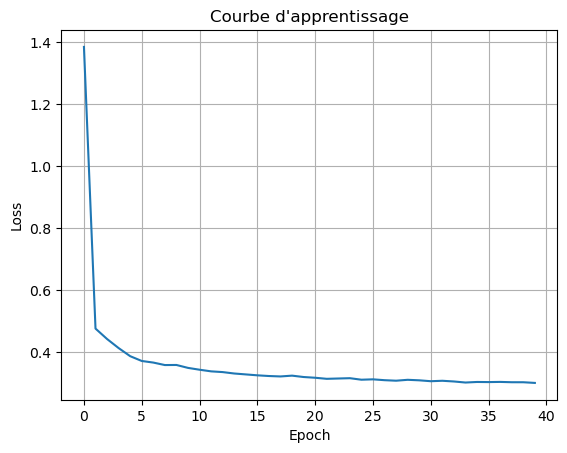

In [14]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe d'apprentissage")
plt.grid()
plt.show()

In [28]:
import torch.nn.functional as F

def predict_on_dataset(model, tasks, device='cpu'):
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        _ = model(X_tensor) # Shape: 1076, 10, 30, 30
        for task_id, task in tasks.items():
            predicted_grids = []
            
            for input_grid in task["train"]:
                input_matrix = input_grid["input"]
                input_tensor = torch.tensor(input_matrix, dtype=torch.long)
                
                # One-hot et padding à 30x30 comme à l'entraînement
                H, W = input_tensor.shape
                onehot = F.one_hot(input_tensor, num_classes=10).permute(2, 0, 1).float()
                padded = torch.zeros((10, 30, 30))
                padded[:, :H, :W] = onehot
                
                pred = model(padded.unsqueeze(0))  # Ajouter batch dim
                pred_labels = torch.argmax(pred.squeeze(0), dim=0)  # C x H x W → H x W
                predicted_grids.append(pred_labels.numpy().tolist())

            predictions[task_id] = predicted_grids
    
    return predictions


In [29]:
predicted_outputs = predict_on_dataset(model, challenges)

In [30]:
# Comparaison entre les prédictions du modèle et les solutions
def evaluate_predictions(predicted_outputs, true_solutions):
    correct = 0
    total = 0
    detailed_results = []

    for task_id, pred_grids in predicted_outputs.items():
        if task_id not in true_solutions:
            continue  # tâche non présente dans les solutions

        true_grid = true_solutions[task_id]

        for pred_grid in pred_grids:
            is_correct = pred_grid == true_grid
            correct += int(is_correct)
            total += 1
            detailed_results.append({
                "task_id": task_id,
                "correct": is_correct,
                "predicted": pred_grid,
                "expected": true_grid,
            })

    accuracy = correct / total if total > 0 else 0
    return {"accuracy": accuracy, "details": detailed_results}



In [31]:
results = evaluate_predictions(predicted_outputs, solutions)

import pandas as pd
df_results = pd.DataFrame(results["details"])

print("Accuracy globale :", results["accuracy"])
display(df_results.head())


Accuracy globale : 0.0


,task_id,correct,predicted,expected
0,00576224,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, ..."
1,00576224,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, ..."
2,007bbfb7,False,"[[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0,..."
3,007bbfb7,False,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0,..."
4,007bbfb7,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0,..."


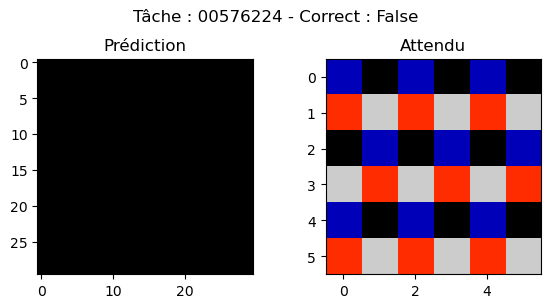

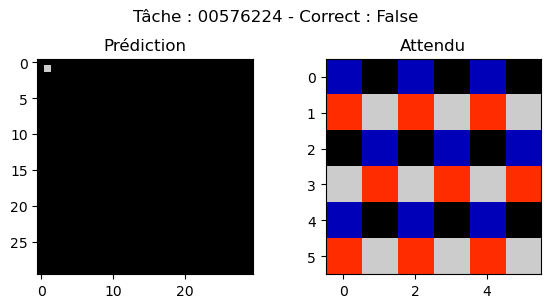

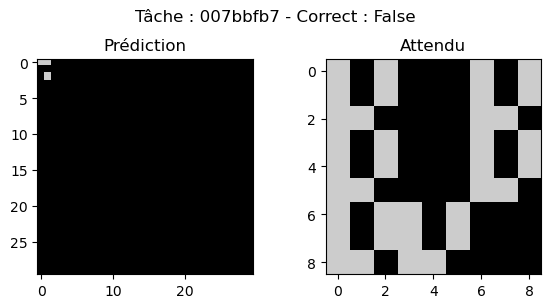

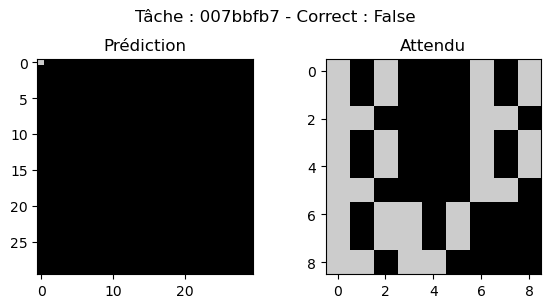

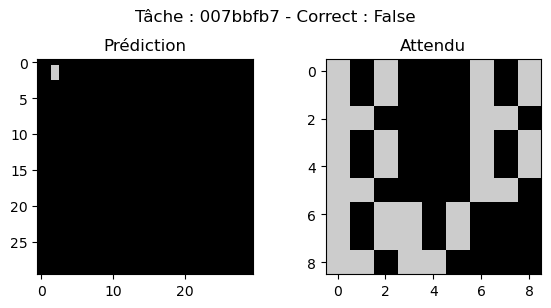

In [32]:
# Aucune prédiction réussie. On va regarder ce qui cloche. On va regarder quelques grilles prédites et les comparer avec celles attendues
def plot_grids(predicted, expected, title=""):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(predicted, cmap="nipy_spectral", interpolation="nearest")
    axs[0].set_title("Prédiction")
    axs[1].imshow(expected, cmap="nipy_spectral", interpolation="nearest")
    axs[1].set_title("Attendu")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Affiche les 5 premiers cas d'erreur
for row in results["details"][:5]:
    expected_grid = row["expected"]
    if isinstance(expected_grid, list) and isinstance(expected_grid[0][0], list):
        expected_grid = expected_grid[0]  # on prend la première grille attendue

    plot_grids(row["predicted"], expected_grid, title=f"Tâche : {row['task_id']} - Correct : {row['correct']}")


In [33]:
# Notre modèle ne prédit que du noir, donc, que des 0. Il n'apprend donc rien à partir des données d'entraînement.
model.eval()
with torch.no_grad():
    predictions = model(X_tensor)  # shape: [1076, 10, 30, 30]
    predicted_labels = predictions.argmax(dim=1)  # shape: [1076, 30, 30]


In [34]:
# Reconstruction des listes de grilles [H, W] à partir des tenseurs
predicted_outputs = [pred.cpu().numpy().tolist() for pred in predicted_labels]

In [35]:
expected_outputs = [true.cpu().numpy().tolist() for true in Y_tensor.argmax(dim=1)]

In [36]:
print("Type de predicted_outputs :", type(predicted_outputs))

if isinstance(predicted_outputs, list):
    print("Longueur de predicted_outputs :", len(predicted_outputs))
    if len(predicted_outputs) > 0:
        print("Type d'un élément :", type(predicted_outputs[0]))
        if isinstance(predicted_outputs[0], dict):
            print("Clés du premier élément :", predicted_outputs[0].keys())
        elif isinstance(predicted_outputs[0], list):
            print("Dimensions d'une prédiction (shape) :", np.array(predicted_outputs[0]).shape)
elif isinstance(predicted_outputs, dict):
    print("Nombre de tâches :", len(predicted_outputs))
    for i, (k, v) in enumerate(predicted_outputs.items()):
        print(f"Exemple tâche {k} : {type(v)}")
        break

try:
    print("Exemple de task_id dans le dataset :", list(challenges.keys())[:5])
except:
    print("Impossible de récupérer training_challenges.")


Type de predicted_outputs : <class 'list'>
Longueur de predicted_outputs : 1076
Type d'un élément : <class 'list'>
Dimensions d'une prédiction (shape) : (30, 30)
Exemple de task_id dans le dataset : ['00576224', '007bbfb7', '009d5c81', '00d62c1b', '00dbd492']


In [37]:
# Y_tensor est en one-hot → on récupère les labels
y_labels = Y_tensor.argmax(dim=1)  # shape: [1076, 30, 30]

# Aplatit tout et compte
labels_flat = y_labels.flatten().cpu().numpy()
import numpy as np
import collections
counter = collections.Counter(labels_flat)

# Affichage
print("Répartition des classes (pixels) dans Y_tensor :")
for k in sorted(counter):
    print(f"Classe {k} : {counter[k]} pixels ({counter[k]/len(labels_flat)*100:.2f}%)")



Répartition des classes (pixels) dans Y_tensor :
Classe 0 : 852923 pixels (88.08%)
Classe 1 : 18862 pixels (1.95%)
Classe 2 : 12489 pixels (1.29%)
Classe 3 : 13746 pixels (1.42%)
Classe 4 : 16426 pixels (1.70%)
Classe 5 : 8142 pixels (0.84%)
Classe 6 : 6035 pixels (0.62%)
Classe 7 : 14794 pixels (1.53%)
Classe 8 : 21614 pixels (2.23%)
Classe 9 : 3369 pixels (0.35%)


In [38]:
# L'intuition était bonne, la classe 0 est prédit à plus de 88%. Donc le modèle ne veut prédire que du noir.
# On va voir ce que ça donne en pondérant la fonction de perte par classe
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

# Calcul des poids
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(10), y=labels_flat)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# CrossEntropy pondérée
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [39]:
# 1. Refait une prédiction
model.eval()
with torch.no_grad():
    output_logits = model(X_tensor)
    predicted_classes = output_logits.argmax(dim=1)  # [1076, 30, 30]

# 2. Associe les task_id
predicted_outputs_dict = {}
task_ids = list(challenges.keys())  # les mêmes que Y_tensor

for task_id, pred in zip(task_ids, predicted_classes):
    predicted_outputs_dict[task_id] = [pred.cpu().numpy().tolist()]  # format [ [grid] ]

# 3. Évaluation : version qui ignore les pixels 0
def evaluate_predictions(predicted_outputs, true_solutions, ignore_value=0):
    total = 0
    correct = 0
    detailed_results = []

    for task_id, pred_grids in predicted_outputs.items():
        if task_id not in true_solutions:
            continue  # tâche non présente dans les solutions

        expected_grids = true_solutions[task_id]  # Liste directe de grilles
        for pred_grid, true_grid in zip(pred_grids, expected_grids):
            match = 0
            count = 0
            for i in range(len(true_grid)):
                for j in range(len(true_grid[0])):
                    if true_grid[i][j] == ignore_value:
                        continue
                    count += 1
                    if pred_grid[i][j] == true_grid[i][j]:
                        match += 1

            if count == 0:
                accuracy = 0
            else:
                accuracy = match / count

            correct += match
            total += count

            detailed_results.append({
                "task_id": task_id,
                "predicted": pred_grid,
                "expected": true_grid,
                "correct": accuracy
            })

    overall_accuracy = correct / total if total > 0 else 0
    return {"accuracy": overall_accuracy, "details": detailed_results}





# Évaluation finale
results = evaluate_predictions(predicted_outputs_dict, solutions)
print("Accuracy (hors fond noir) :", results["accuracy"])



Accuracy (hors fond noir) : 0.04023506403865327


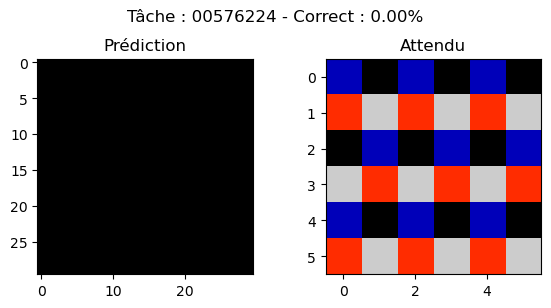

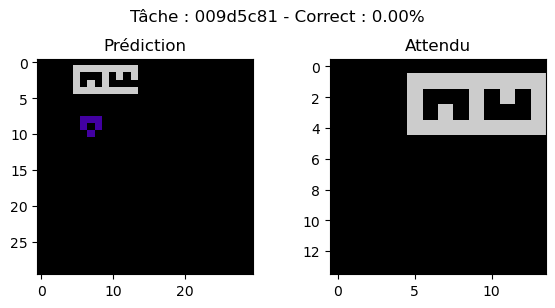

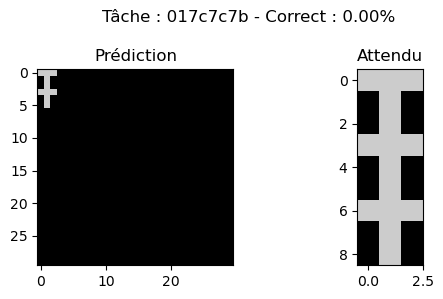

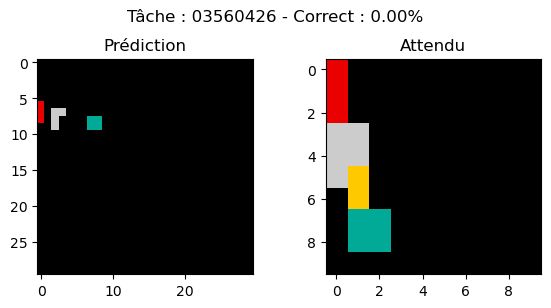

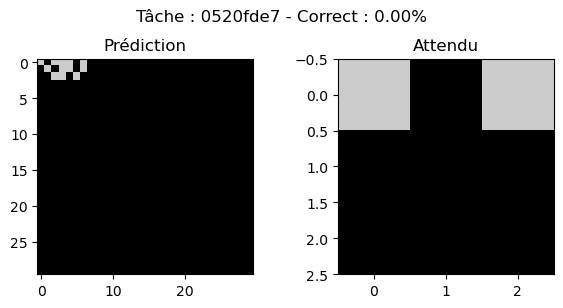

In [40]:
import random

def plot_grids(predicted, expected, title=""):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(predicted, cmap="nipy_spectral", interpolation="nearest")
    axs[0].set_title("Prédiction")
    axs[1].imshow(expected, cmap="nipy_spectral", interpolation="nearest")
    axs[1].set_title("Attendu")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for row in sorted(results["details"], key=lambda x: x["correct"])[:5]:
    plot_grids(row["predicted"], row["expected"], title=f"Tâche : {row['task_id']} - Correct : {row['correct']:.2%}")



In [41]:
def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

with torch.no_grad():
    model.eval()
    logits = model(X_tensor)
    pred_classes = torch.argmax(logits, dim=1)

In [42]:

def random_transform(grid):
    # Rotation (0, 90, 180, 270°)
    k = random.choice([0, 1, 2, 3])
    grid = np.rot90(grid, k)

    # Flip horizontal
    if random.random() < 0.5:
        grid = np.fliplr(grid)

    # Flip vertical
    if random.random() < 0.5:
        grid = np.flipud(grid)
    
    return grid


In [43]:
X_raw = X_tensor.numpy()
Y_raw = Y_tensor.argmax(dim=1).numpy()

X_aug = []
Y_aug = []

for x, y in zip(X_raw, Y_raw):  # X_raw = [10, 30, 30], Y_raw = [30, 30]
    y_trans = random_transform(y)
    x_trans = np.zeros_like(x)
    for c in range(10):
        x_trans[c] = (y_trans == c).astype(np.float32)
    X_aug.append(x_trans)
    Y_aug.append(y_trans)

X_tensor = torch.tensor(X_aug, dtype=torch.float32)
Y_tensor = torch.nn.functional.one_hot(torch.tensor(Y_aug), num_classes=10).permute(0, 3, 1, 2).float()

C:\Users\hamon\AppData\Local\Temp\ipykernel_20324\1804060153.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  X_tensor = torch.tensor(X_aug, dtype=torch.float32)


In [44]:
n_augmentations = 5  # ← Tu peux changer à 3, 10, etc.

for _ in range(n_augmentations):
    for x, y in zip(X_raw, Y_raw):
        y_trans = random_transform(y)
        x_trans = np.zeros_like(x)
        for c in range(10):
            x_trans[c] = (y_trans == c).astype(np.float32)
        X_aug.append(x_trans)
        Y_aug.append(y_trans)

# Inclu aussi les données originales
X_aug.extend(X_raw)
Y_aug.extend(Y_raw)

# Conversion
X_tensor = torch.tensor(X_aug, dtype=torch.float32)
Y_tensor = torch.nn.functional.one_hot(torch.tensor(Y_aug), num_classes=10).permute(0, 3, 1, 2).float()

print("Données augmentées :", X_tensor.shape, Y_tensor.shape)

Données augmentées : torch.Size([7532, 10, 30, 30]) torch.Size([7532, 10, 30, 30])


In [45]:
class ARCConvNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_classes, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)  # pas besoin d'activation ici, CrossEntropyLoss s'en charge
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch 01 | Train Loss: 0.6818 | Val Loss: 0.3160 | Val Acc: 0.9453
Epoch 02 | Train Loss: 0.2950 | Val Loss: 0.2399 | Val Acc: 0.9509
Epoch 03 | Train Loss: 0.2811 | Val Loss: 0.2106 | Val Acc: 0.9531
Epoch 04 | Train Loss: 0.2583 | Val Loss: 0.2129 | Val Acc: 0.9539
Epoch 05 | Train Loss: 0.2516 | Val Loss: 0.2099 | Val Acc: 0.9525
Epoch 06 | Train Loss: 0.2378 | Val Loss: 0.2060 | Val Acc: 0.9534
Epoch 07 | Train Loss: 0.2405 | Val Loss: 0.2532 | Val Acc: 0.9435
Epoch 08 | Train Loss: 0.2354 | Val Loss: 0.2063 | Val Acc: 0.9536
Epoch 09 | Train Loss: 0.2227 | Val Loss: 0.1900 | Val Acc: 0.9545
Epoch 10 | Train Loss: 0.2208 | Val Loss: 0.2068 | Val Acc: 0.9544
Epoch 11 | Train Loss: 0.2209 | Val Loss: 0.1939 | Val Acc: 0.9543
Epoch 12 | Train Loss: 0.2150 | Val Loss: 0.2023 | Val Acc: 0.9543
Epoch 13 | Train Loss: 0.2182 | Val Loss: 0.1967 | Val Acc: 0.9548
Epoch 14 | Train Loss: 0.2021 | Val Loss: 0.1864 | Val Acc: 0.9547
Epoch 15 | Train Loss: 0.2009 | Val Loss: 0.1932 | Val Acc: 0.

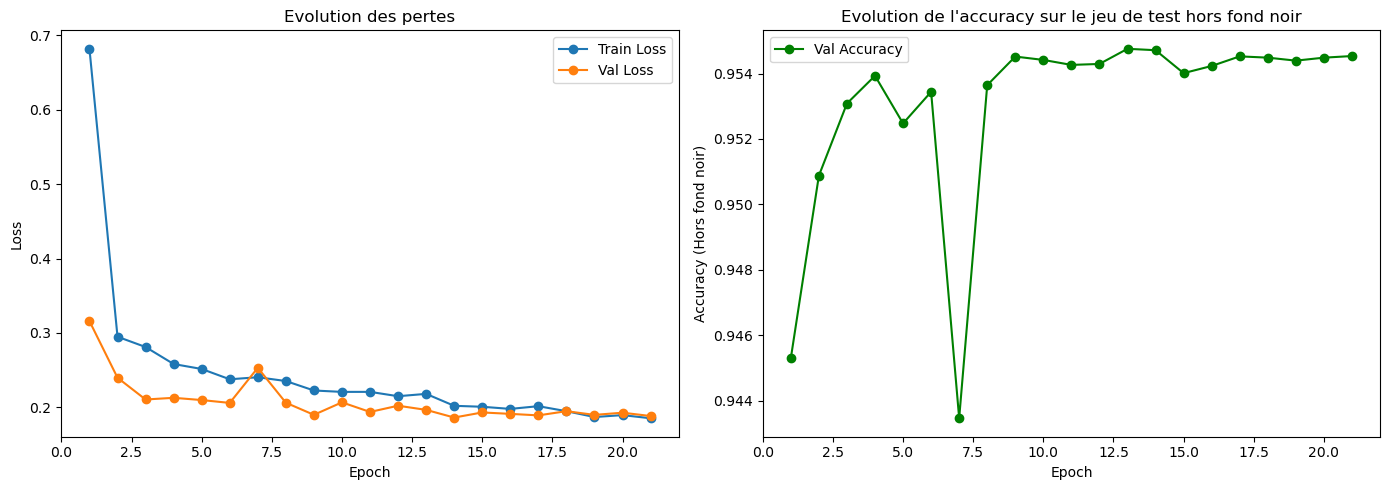

In [46]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ARCConvNetV2().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Loss pondérée pour lutter contre la classe 0
weights = torch.tensor([0.05] + [1.0] * 9).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=32)

# Accuracy sans fond noir
def accuracy_no_background(preds, targets):
    preds = preds.argmax(1)
    targets = targets.argmax(1)
    mask = targets != 0
    correct = (preds[mask] == targets[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0

# Initialisation des suivis
train_losses, val_losses, val_accuracies = [], [], []

best_val_acc = 0
best_model = None
patience_counter = 0
max_patience = 8

for epoch in range(40):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = criterion(out, yb.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb.argmax(dim=1))
            val_loss += loss.item()
            val_acc += accuracy_no_background(out, yb)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    old_lr = optimizer.param_groups[0]['lr']
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < old_lr:
        print(f"Learning rate réduit : {old_lr: .5f} -> {new_lr: .5f}")

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print(f"Early stopping at epoch {epoch+1} with best val acc {best_val_acc:.4f}")
            break

# Chargement du meilleur modèle
model.load_state_dict(best_model)

# Courbes
epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution des pertes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Val Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (Hors fond noir)")
plt.title("Evolution de l'accuracy sur le jeu de test hors fond noir")
plt.legend()

plt.tight_layout()
plt.show()

Accuracy globale (sans fond noir) : 0.04023506403865327


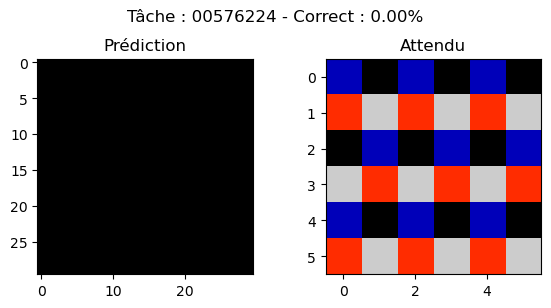

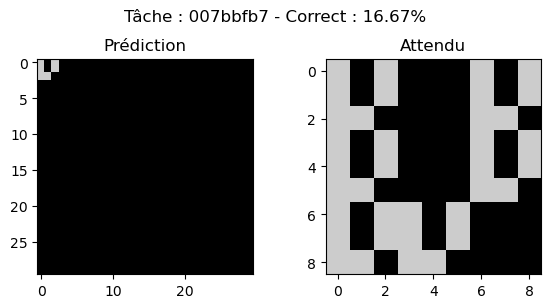

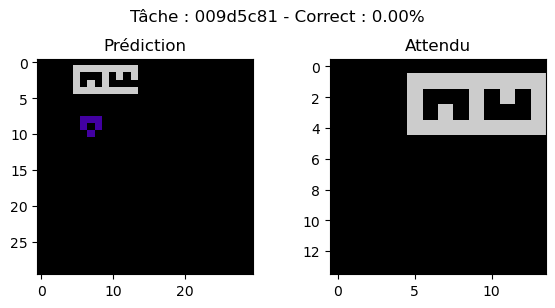

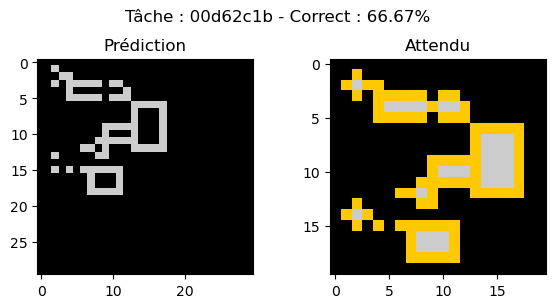

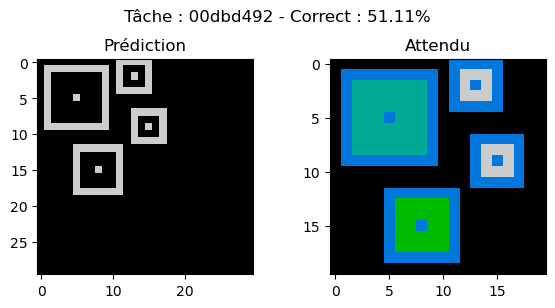

In [48]:
results = evaluate_predictions(predicted_outputs_dict, solutions)
print("Accuracy globale (sans fond noir) :", results["accuracy"])

for row in results["details"][:5]:
    plot_grids(row["predicted"], row["expected"], title=f"Tâche : {row['task_id']} - Correct : {row['correct']:.2%}")

In [51]:
from scipy.ndimage import label

def extract_symbolic_features(grid):
    grid = np.array(grid)
    features = {}

    # Dimensions de la grille
    features["height"] = grid.shape[0]
    features["width"] = grid.shape[1]

    # Couleurs utilisées
    unique_colors, counts = np.unique(grid, return_counts=True)
    features["num_colors"] = len(unique_colors)
    for color in range(10):
        features[f"count_color_{color}"] = counts[unique_colors.tolist().index(color)] if color in unique_colors else 0

    # Nombre d'objets (par couleur)
    for color in range(1, 10):  # on ignore 0 (le fond)
        binary_mask = (grid == color).astype(int)
        structure = np.ones((3, 3))  # connexité 8
        labeled, num_features = label(binary_mask, structure=structure)
        features[f"num_objects_color_{color}"] = num_features

    return features

def extract_symbolic_features_all_tasks(challenges):
    data = []

    for task_id, task in challenges.items():
        for input_id, sample in enumerate(task["train"]):
            input_grid = np.array(sample["input"])
            output_grid = np.array(sample["output"])
            features = extract_symbolic_features(input_grid)
            features["task_id"] = task_id
            features["input_id"] = input_id
            features["output_grid"] = output_grid  # On garde le label associé
            data.append(features)

    return pd.DataFrame(data)

df_features = extract_symbolic_features_all_tasks(challenges)

In [52]:
from scipy.ndimage import center_of_mass

def extract_symbolic_features(grid):
    grid = np.array(grid)
    features = []

    # Base: shape
    H, W = grid.shape
    features.append(H)
    features.append(W)

    # Couleurs présentes et nombre total
    unique_colors, counts = np.unique(grid, return_counts=True)
    num_colors = len(unique_colors)
    features.append(num_colors)

    # Compter les pixels par couleur (0 à 9)
    for c in range(10):
        features.append(counts[unique_colors.tolist().index(c)] if c in unique_colors else 0)

    # Objets (par couleur 1 à 9)
    for c in range(1, 10): # On ignore le 0 (fond)
        mask = (grid == c).astype(int)
        struct = np.ones((3, 3))
        labeled, num = label(mask, structure=struct)
        features.append(num) # nb objets

        if num > 0:
            sizes = [(labeled == i).sum() for i in range(1, num + 1)]
            features.append(np.mean(sizes))
            features.append(np.std(sizes))

            centers = center_of_mass(mask, labeled, range(1, num + 1))
            xs, ys = zip(*centers)
            features.append(np.mean(xs))
            features.append(np.mean(ys))
        else:
            features += [0, 0, 0, 0]

    return np.array(features, dtype=np.float32)

# Application à toutes les grilles d'entraînement
symbolic_features = []
for task_id, task in challenges.items():
    for sample in task["train"]:
        input_grid = sample["input"]
        features = extract_symbolic_features(input_grid)
        symbolic_features.append(features)

symbolic_tensor = torch.tensor(np.array(symbolic_features)) # Shape (N, D)

print("Features symboliques extraites :", symbolic_tensor.shape)

Features symboliques extraites : torch.Size([3232, 58])


In [58]:
# Nettoyage du dataframe des features symboliques
df_clean = df_features.drop(columns=["task_id", "input_id"]).copy()

# Force les valeurs non numériques à NaN puis les rempli avec 0
df_clean = df_clean.apply(pd.to_numeric, errors='coerce').fillna(0)

# Conversion en tenseur float32
X_features_tensor = torch.tensor(df_clean.values, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Architecture du modèle hybride
class ARCHybridNet(nn.Module):
    def __init__(self, feature_dim, num_classes=10):
        super().__init__()
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(num_classes, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.fusion = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)  # output logits
        )

    def forward(self, image, features):
        x_cnn = self.cnn_branch(image)  # shape B x 64 x 30 x 30
        x_feat = self.feature_branch(features)  # shape B x 64
        x_feat = x_feat.view(x_feat.size(0), 64, 1, 1).expand(-1, -1, 30, 30)
        x = torch.cat([x_cnn, x_feat], dim=1)
        return self.fusion(x)  # B x num_classes x 30 x 30

# Préparation des données
# Split
# On extrait les indices valides (i.e. features calculés)
valid_indices = df_features["task_id"].astype(str) + "_" + df_features["input_id"].astype(str)

# Construction des index en string à partir des données originales (challenges/train)
all_ids = []
for task_id, content in challenges.items():
    for i, pair in enumerate(content["train"]):
        all_ids.append(f"{task_id}_{i}")

# Création d'une table de correspondance
id_to_index = {f"{task_id}_{i}": idx for idx, (task_id, content) in enumerate(challenges.items()) for i in range(len(content["train"]))}

# Filtrage : on garde uniquement les index présents dans valid_indices
selected_indices = [id_to_index[uid] for uid in valid_indices if uid in id_to_index]

# Application du filtrage
X_tensor_sel = X_tensor[selected_indices]
Y_tensor_sel = Y_tensor[selected_indices]
X_features_tensor_sel = X_features_tensor  # déjà aligné avec df_features

# Sanity check
print(X_tensor_sel.shape, X_features_tensor_sel.shape, Y_tensor_sel.shape)

X_train_img, X_val_img, X_train_feat, X_val_feat, Y_train, Y_val = train_test_split(
    X_tensor_sel, X_features_tensor_sel, Y_tensor_sel, test_size=0.2, random_state=42)


train_ds = TensorDataset(X_train_img, X_train_feat, Y_train)
val_ds = TensorDataset(X_val_img, X_val_feat, Y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Entraînement
model = ARCHybridNet(feature_dim=X_features_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
weights = torch.tensor([0.05] + [1.0] * 9).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

best_val_acc = 0
best_model = None
patience = 8
patience_counter = 0

train_losses, val_losses, val_accuracies = [], [], []

def accuracy_no_background(preds, targets):
    preds = preds.argmax(1)
    targets = targets.argmax(1)
    mask = targets != 0
    correct = (preds[mask] == targets[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0

for epoch in range(40):
    model.train()
    train_loss = 0
    for xb_img, xb_feat, yb in train_loader:
        xb_img, xb_feat, yb = xb_img.to(device), xb_feat.to(device), yb.to(device)
        out = model(xb_img, xb_feat)
        loss = criterion(out, yb.argmax(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for xb_img, xb_feat, yb in val_loader:
            xb_img, xb_feat, yb = xb_img.to(device), xb_feat.to(device), yb.to(device)
            out = model(xb_img, xb_feat)
            loss = criterion(out, yb.argmax(1))
            val_loss += loss.item()
            val_acc += accuracy_no_background(out, yb)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with best val acc {best_val_acc:.4f}")
            break

model.load_state_dict(best_model)


torch.Size([3232, 10, 30, 30]) torch.Size([3232, 23]) torch.Size([3232, 10, 30, 30])
Epoch 01 | Train Loss: 1.2562 | Val Loss: 0.6044 | Val Acc: 0.7572
Epoch 02 | Train Loss: 0.4407 | Val Loss: 0.3725 | Val Acc: 0.8520
Epoch 03 | Train Loss: 0.2335 | Val Loss: 0.1662 | Val Acc: 0.9374
Epoch 04 | Train Loss: 0.1040 | Val Loss: 0.0831 | Val Acc: 0.9694
Epoch 05 | Train Loss: 0.0513 | Val Loss: 0.0451 | Val Acc: 0.9846
Epoch 06 | Train Loss: 0.0274 | Val Loss: 0.0259 | Val Acc: 0.9927
Epoch 07 | Train Loss: 0.0160 | Val Loss: 0.0147 | Val Acc: 0.9968
Epoch 08 | Train Loss: 0.0094 | Val Loss: 0.0094 | Val Acc: 0.9984
Epoch 09 | Train Loss: 0.0062 | Val Loss: 0.0064 | Val Acc: 0.9991
Epoch 10 | Train Loss: 0.0042 | Val Loss: 0.0047 | Val Acc: 0.9994
Epoch 11 | Train Loss: 0.0031 | Val Loss: 0.0035 | Val Acc: 0.9997
Epoch 12 | Train Loss: 0.0023 | Val Loss: 0.0026 | Val Acc: 0.9998
Epoch 13 | Train Loss: 0.0017 | Val Loss: 0.0020 | Val Acc: 0.9999
Epoch 14 | Train Loss: 0.0013 | Val Loss: 0.

<All keys matched successfully>

In [65]:
# Réalignement des X et Y avec df_features

# On garde les indices des inputs utilisés pour les features
input_indices = df_features[["task_id", "input_id"]].reset_index(drop=True)

# Création d’une liste d’index correspondant dans X_tensor et Y_tensor
aligned_idx = []
global_idx = 0
task_input_count = {}

for task_id in challenges:
    task_input_count[task_id] = len(challenges[task_id]["train"])

for task_id in challenges:
    for i in range(task_input_count[task_id]):
        if ((input_indices["task_id"] == task_id) & (input_indices["input_id"] == i)).any():
            aligned_idx.append(global_idx)
        global_idx += 1

# Sous-échantillonnage de X et Y
X_tensor_aligned = X_tensor[aligned_idx]
Y_tensor_aligned = Y_tensor[aligned_idx]

# Vérification
print("X_tensor aligned:", X_tensor_aligned.shape)
print("Y_tensor aligned:", Y_tensor_aligned.shape)
print("X_features_tensor:", X_features_tensor.shape)

# On peut maintenant refaire un split correct
X_train_img, X_val_img, X_train_feat, X_val_feat, Y_train, Y_val = train_test_split(
    X_tensor_aligned, X_features_tensor, Y_tensor_aligned, test_size=0.2, random_state=42)

print(f"Final shapes: {X_train_img.shape}, {X_val_img.shape}")

X_tensor aligned: torch.Size([3232, 10, 30, 30])
Y_tensor aligned: torch.Size([3232, 10, 30, 30])
X_features_tensor: torch.Size([3232, 23])
Final shapes: torch.Size([2585, 10, 30, 30]), torch.Size([647, 10, 30, 30])


In [66]:
# On va approfondir notre modèle, en utilisant maintenant l'ensemble des données d'entraînement
# On met à jour la fonction extract_symbolic_features_all_tasks() pour extraire les features symboliques pour TOUS les inputs de tous les train des tâches
def extract_symbolic_features_all_tasks(challenges):
    data = []
    for task_id, task in challenges.items():
        for i, sample in enumerate(task["train"]):
            input_grid = np.array(sample["input"])
            output_grid = np.array(sample["output"])
            features = extract_symbolic_features(input_grid)
            features["task_id"] = task_id
            features["pair_index"] = i  # identifie chaque paire train[i]
            data.append(features)
    return pd.DataFrame(data)

In [78]:
from sklearn.preprocessing import StandardScaler

# EXTRACTION DES FEATURES SYMBOLIQUES POUR TOUS LES 'train'

X_data = []
Y_data = []
task_ids = []
pair_indices = []

for task_id, task in challenges.items():
    for i, sample in enumerate(task["train"]):
        X_data.append(sample["input"])
        Y_data.append(sample["output"])
        task_ids.append(task_id)
        pair_indices.append(i)


def extract_symbolic_features(input_grid, output_grid):
    from scipy.ndimage import label
    from skimage.measure import regionprops
    import numpy as np

    input = np.array(input_grid)
    output = np.array(output_grid)

    def extract_props(grid):
        labeled, _ = label(grid != 0)
        props = regionprops(labeled)
        return props, labeled

    props_in, labels_in = extract_props(input)
    props_out, labels_out = extract_props(output)

    # Nombres d'objets
    n_obj_in = len(props_in)
    n_obj_out = len(props_out)

    # Surface totale
    surface_in = sum(p.area for p in props_in)
    surface_out = sum(p.area for p in props_out)

    # Couleurs utilisées
    colors_in = np.unique(input[input > 0])
    colors_out = np.unique(output[output > 0])

    # Changements simples
    color_change = int(not np.array_equal(np.sort(colors_in), np.sort(colors_out)))
    added_objects = max(0, n_obj_out - n_obj_in)
    removed_objects = max(0, n_obj_in - n_obj_out)
    surface_diff = surface_out - surface_in

    # Bounding box moyenne
    avg_aspect_in = np.mean([p.bbox_area / (p.area + 1e-5) for p in props_in]) if props_in else 0
    avg_aspect_out = np.mean([p.bbox_area / (p.area + 1e-5) for p in props_out]) if props_out else 0

    # Estimation de translations (approx)
    translation_detected = 0
    if n_obj_in == n_obj_out and n_obj_in > 0:
        translation_detected = int(any(
            np.linalg.norm(np.array(p_out.centroid) - np.array(p_in.centroid)) > 1e-2
            for p_in, p_out in zip(props_in, props_out)
        ))

    # Changement de symétrie (approx)
    symmetry_in = int(np.array_equal(input, np.fliplr(input)) or np.array_equal(input, np.flipud(input)))
    symmetry_out = int(np.array_equal(output, np.fliplr(output)) or np.array_equal(output, np.flipud(output)))
    symmetry_changed = int(symmetry_in != symmetry_out)

    # Masque : on regarde uniquement les pixels non noirs de l'input
    if input.shape == output.shape:
        mask = input > 0
        color_replacement_ratio = (
            np.mean(input[mask] != output[mask]) if np.any(mask) else 0
        )
    else:
        color_replacement_ratio = 0  # forme incompatible


    if input.shape == output.shape:
        nonzero_overlap_ratio = (
            np.mean((input > 0) & (output > 0)) if np.any((input > 0) | (output > 0)) else 0
        )
    else:
        nonzero_overlap_ratio = 0


    return {
        "n_objects_in": n_obj_in,
        "n_objects_out": n_obj_out,
        "surface_in": surface_in,
        "surface_out": surface_out,
        "surface_diff": surface_diff,
        "n_colors_in": len(colors_in),
        "n_colors_out": len(colors_out),
        "color_change": color_change,
        "added_objects": added_objects,
        "removed_objects": removed_objects,
        "avg_aspect_in": avg_aspect_in,
        "avg_aspect_out": avg_aspect_out,
        "symmetry_changed": symmetry_changed,
        "translation_detected": translation_detected,
        "is_rotation": int(np.array_equal(np.rot90(input), output)),
        "is_flip_horizontal": int(np.array_equal(np.fliplr(input), output)),
        "is_flip_vertical": int(np.array_equal(np.flipud(input), output)),
        "is_identity": int(np.array_equal(input, output)),
        "color_replacement_ratio": color_replacement_ratio,
        "nonzero_overlap_ratio": nonzero_overlap_ratio,
    }


def extract_symbolic_features_all_tasks(challenges):
    data = []
    errors = []

    for task_id, task in challenges.items():
        for i, sample in enumerate(task["train"]):
            input_grid = np.array(sample["input"])
            output_grid = np.array(sample["output"])
            try:
                features = extract_symbolic_features(input_grid, output_grid)
                features["task_id"] = task_id
                features["pair_index"] = i
                data.append(features)
            except Exception as e:
                errors.append((task_id, i, str(e)))

    print(f"Extraits : {len(data)} | Erreurs : {len(errors)}")
    if errors:
        print("Quelques erreurs rencontrées :")
        for err in errors[:5]:
            print(err)

    return pd.DataFrame(data)



df_features = extract_symbolic_features_all_tasks(challenges)

# CONSTRUCTION DES TENSEURS IMAGE & FEATURES

# One-hot pour les inputs
def to_tensor_onehot_grids(grids, num_classes=10, target_size=30):
    tensors = []
    for grid in grids:
        h, w = len(grid), len(grid[0])
        grid_tensor = torch.tensor(grid, dtype=torch.long)
        onehot = torch.nn.functional.one_hot(grid_tensor, num_classes=num_classes)
        onehot = onehot.permute(2, 0, 1).float()  # [C, H, W]

        # Padding pour atteindre target_size x target_size
        pad_h = target_size - h
        pad_w = target_size - w
        padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
        onehot_padded = torch.nn.functional.pad(onehot, padding)

        tensors.append(onehot_padded)
    return torch.stack(tensors)


# Inputs / Outputs / Features
X_tensor = to_tensor_onehot_grids(X_data, num_classes=10)
Y_tensor = to_tensor_onehot_grids(Y_data, num_classes=10)

# Nettoyage des features symboliques
symbolic_data = df_features.drop(columns=["task_id", "pair_index"])
symbolic_data = symbolic_data.select_dtypes(include=["number"]).fillna(0)

# Standardisation
scaler = StandardScaler()
symbolic_scaled = scaler.fit_transform(symbolic_data)
X_features_tensor = torch.tensor(symbolic_scaled, dtype=torch.float32)

# Vérification des tailles
print("X_tensor:", X_tensor.shape)
print("Y_tensor:", Y_tensor.shape)
print("X_features_tensor:", X_features_tensor.shape)

Extraits : 3232 | Erreurs : 0
X_tensor: torch.Size([3232, 10, 30, 30])
Y_tensor: torch.Size([3232, 10, 30, 30])
X_features_tensor: torch.Size([3232, 20])


In [105]:
from skimage.measure import regionprops

# Chargement des fichiers

with open("../data/arc-agi_training_challenges.json") as f:
    training_data = json.load(f)

with open("../data/arc-agi_training_solutions.json") as f:
    training_solutions = json.load(f)

with open("../data/arc-agi_evaluation_challenges.json") as f:
    eval_data = json.load(f)

with open("../data/arc-agi_evaluation_solutions.json") as f:
    eval_solutions = json.load(f)

# On fusionne tous les exemples disponibles

def extract_all_pairs(challenges_dict, solutions_dict):
    inputs, outputs, task_ids, pair_ids = [], [], [], []

    for task_id, task in challenges_dict.items():
        if task_id not in solutions_dict:
            continue

        test_outputs = solutions_dict[task_id]
        test_inputs = task["test"]
        assert len(test_outputs) == len(test_inputs), f"Mismatch for {task_id}"

        for i, (train_pair, output) in enumerate(zip(test_inputs, test_outputs)):
            input_grid = train_pair["input"]
            output_grid = output
            inputs.append(input_grid)
            outputs.append(output_grid)
            task_ids.append(task_id)
            pair_ids.append(f"test_{i}")

        for i, train_pair in enumerate(task["train"]):
            inputs.append(train_pair["input"])
            outputs.append(train_pair["output"])
            task_ids.append(task_id)
            pair_ids.append(f"train_{i}")

    return inputs, outputs, task_ids, pair_ids

X_data, Y_data, task_ids, pair_ids = [], [], [], []

for dataset in [(training_data, training_solutions), (eval_data, eval_solutions)]:
    X_part, Y_part, task_part, pair_part = extract_all_pairs(*dataset)
    X_data.extend(X_part)
    Y_data.extend(Y_part)
    task_ids.extend(task_part)
    pair_ids.extend(pair_part)

print("Nombre total de paires :", len(X_data))

# Conversion en tenseurs

def to_tensor_onehot_grids(grids, num_classes=10, target_size=30):
    tensors = []
    for grid in grids:
        h, w = len(grid), len(grid[0])
        grid_tensor = torch.tensor(grid, dtype=torch.long)
        onehot = torch.nn.functional.one_hot(grid_tensor, num_classes=num_classes)
        onehot = onehot.permute(2, 0, 1).float()
        padding = (0, target_size - w, 0, target_size - h)
        onehot_padded = torch.nn.functional.pad(onehot, padding)
        tensors.append(onehot_padded)
    return torch.stack(tensors)

X_tensor = to_tensor_onehot_grids(X_data, num_classes=10)
Y_tensor = to_tensor_onehot_grids(Y_data, num_classes=10)

# Extraction des features symboliques

def extract_symbolic_features(input, output):
    def extract_props(grid):
        labeled, _ = label(grid != 0)
        return regionprops(labeled)

    input, output = np.array(input), np.array(output)
    props_in, props_out = extract_props(input), extract_props(output)
    n_obj_in, n_obj_out = len(props_in), len(props_out)
    surface_in = sum(p.area for p in props_in)
    surface_out = sum(p.area for p in props_out)
    colors_in = np.unique(input[input > 0])
    colors_out = np.unique(output[output > 0])
    color_change = int(not np.array_equal(np.sort(colors_in), np.sort(colors_out)))
    added_objects = max(0, n_obj_out - n_obj_in)
    removed_objects = max(0, n_obj_in - n_obj_out)
    surface_diff = surface_out - surface_in
    avg_aspect_in = np.mean([p.bbox_area / (p.area + 1e-5) for p in props_in]) if props_in else 0
    avg_aspect_out = np.mean([p.bbox_area / (p.area + 1e-5) for p in props_out]) if props_out else 0
    translation_detected = 0
    if n_obj_in == n_obj_out and n_obj_in > 0:
        translation_detected = int(any(np.linalg.norm(np.array(p_out.centroid) - np.array(p_in.centroid)) > 1e-2 for p_in, p_out in zip(props_in, props_out)))
    symmetry_in = int(np.array_equal(input, np.fliplr(input)) or np.array_equal(input, np.flipud(input)))
    symmetry_out = int(np.array_equal(output, np.fliplr(output)) or np.array_equal(output, np.flipud(output)))
    symmetry_changed = int(symmetry_in != symmetry_out)
    if input.shape == output.shape:
        mask = input > 0
        color_replacement_ratio = np.mean(input[mask] != output[mask]) if np.any(mask) else 0
        nonzero_overlap_ratio = np.mean((input > 0) & (output > 0)) if np.any((input > 0) | (output > 0)) else 0
    else:
        color_replacement_ratio = 0
        nonzero_overlap_ratio = 0

    return [
        n_obj_in, n_obj_out, surface_in, surface_out, surface_diff,
        len(colors_in), len(colors_out), color_change,
        added_objects, removed_objects, avg_aspect_in, avg_aspect_out,
        symmetry_changed, translation_detected,
        int(np.array_equal(np.rot90(input), output)),
        int(np.array_equal(np.fliplr(input), output)),
        int(np.array_equal(np.flipud(input), output)),
        int(np.array_equal(input, output)),
        color_replacement_ratio, nonzero_overlap_ratio
    ]

symbolic_features = [extract_symbolic_features(inp, out) for inp, out in zip(X_data, Y_data)]
X_features_tensor = torch.tensor(symbolic_features, dtype=torch.float32)
scaler = StandardScaler()
X_features_norm = scaler.fit_transform(X_features_tensor)  # Fit and transform the tensor
X_features_tensor = torch.tensor(X_features_norm, dtype=torch.float32)

# 5. Vérification finale

print("X_tensor:", X_tensor.shape)
print("Y_tensor:", Y_tensor.shape)
print("X_features_tensor:", X_features_tensor.shape)

Nombre total de paires : 4838
X_tensor: torch.Size([4838, 10, 30, 30])
Y_tensor: torch.Size([4838, 10, 30, 30])
X_features_tensor: torch.Size([4838, 20])


In [107]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Architecture fusionnée
class ARCFusionNetV4(nn.Module):
    def __init__(self, num_classes=10, in_channels=10, feature_dim=20):
        super().__init__()

        # Branche image (CNN)
        self.cnn = nn.Sequential(
            # Couche 1 - 10 Canaux -> 128 canaux
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            # Couche 2 - 128 canaux -> 128 canaux
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15

            # Couche 3 - 128 canaux -> 128 canaux
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            # Couche 4 - 128 canaux -> 128 canaux
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(3),  # 5x5

            nn.Flatten()
        )
        self.cnn_out_dim = 128 * 5 * 5

        # Branche features symboliques
        self.dense = nn.Sequential(
            nn.Linear(feature_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU()
        )

        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(self.cnn_out_dim + 64, 1024), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes * 30 * 30)
        )

    def forward(self, x_img, x_feat):
        img_feat = self.cnn(x_img)
        feat_feat = self.dense(x_feat)
        fusion = torch.cat([img_feat, feat_feat], dim=1)
        out = self.fusion(fusion)
        return out.view(-1, 10, 30, 30)

# Split 80/20
X_img_train, X_img_val, X_feat_train, X_feat_val, Y_train, Y_val = train_test_split(
    X_tensor, X_features_tensor, Y_tensor, test_size=0.2, random_state=42)

train_ds = TensorDataset(X_img_train, X_feat_train, Y_train)
val_ds = TensorDataset(X_img_val, X_feat_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Fonction de précision (hors fond noir)
def accuracy_no_black(preds, targets):
    preds = preds.argmax(1)
    targets = targets.argmax(1)
    mask = targets != 0
    correct = (preds[mask] == targets[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0

# Entraînement
model = ARCFusionNetV4().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
class_counts = torch.bincount(Y_tensor.argmax(1).flatten())
weights = 1. / (class_counts + 1e-5)
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

best_model = None
best_val_acc = 0
patience = 6
patience_counter = 0

train_losses = []
val_losses = []
val_accuracies = []

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
model.apply

for epoch in range(40):
    model.train()
    train_loss = 0
    for xb, xf, yb in train_loader:
        xb, xf, yb = xb.to(device), xf.to(device), yb.to(device)
        preds = model(xb, xf)
        loss = criterion(preds, yb.argmax(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for xb, xf, yb in val_loader:
            xb, xf, yb = xb.to(device), xf.to(device), yb.to(device)
            preds = model(xb, xf)
            loss = criterion(preds, yb.argmax(1))
            val_loss += loss.item()
            val_acc += accuracy_no_black(preds, yb)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, best val acc: {best_val_acc:.4f}")
            break

# Chargement du meilleur modèle
model.load_state_dict(best_model)

Epoch 01 | Train Loss: 2.0287 | Val Loss: 1.8095 | Val Acc: 0.3456
Epoch 02 | Train Loss: 1.7835 | Val Loss: 1.6611 | Val Acc: 0.4049
Epoch 03 | Train Loss: 1.6375 | Val Loss: 1.5983 | Val Acc: 0.4516
Epoch 04 | Train Loss: 1.5610 | Val Loss: 1.5641 | Val Acc: 0.4482
Epoch 05 | Train Loss: 1.5150 | Val Loss: 1.5535 | Val Acc: 0.4812
Epoch 06 | Train Loss: 1.4667 | Val Loss: 1.5112 | Val Acc: 0.4904
Epoch 07 | Train Loss: 1.4263 | Val Loss: 1.4838 | Val Acc: 0.5062
Epoch 08 | Train Loss: 1.3896 | Val Loss: 1.4765 | Val Acc: 0.5090
Epoch 09 | Train Loss: 1.3485 | Val Loss: 1.4773 | Val Acc: 0.4957
Epoch 10 | Train Loss: 1.3201 | Val Loss: 1.4512 | Val Acc: 0.5052
Epoch 11 | Train Loss: 1.2854 | Val Loss: 1.4362 | Val Acc: 0.5122
Epoch 12 | Train Loss: 1.2545 | Val Loss: 1.4155 | Val Acc: 0.5119
Epoch 13 | Train Loss: 1.2381 | Val Loss: 1.4298 | Val Acc: 0.5122
Epoch 14 | Train Loss: 1.2184 | Val Loss: 1.4448 | Val Acc: 0.5098
Epoch 15 | Train Loss: 1.1923 | Val Loss: 1.4120 | Val Acc: 0.

<All keys matched successfully>

In [101]:
# Liste toutes les variables avec leur type et taille (ou longueur)
var_name = []
var_value = []

for var_name, var_value in globals().items():
    if not var_name.startswith("_"):  # ignore les variables internes
        try:
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: shape={var_value.shape}")
            elif hasattr(var_value, '__len__'):
                print(f"{var_name}: len={len(var_value)}")
            else:
                print(f"{var_name}: type={type(var_value)}")
        except:
            print(f"{var_name}: type={type(var_value)} (erreur de lecture)")


In: len=102
Out: len=15
get_ipython: type=<class 'method'>
exit: type=<class 'IPython.core.autocall.ZMQExitAutocall'>
quit: type=<class 'IPython.core.autocall.ZMQExitAutocall'>
open: type=<class 'function'>
json: type=<class 'module'>
Counter: type=<class 'type'> (erreur de lecture)
pd: type=<class 'module'>
plt: type=<class 'module'>
f: type=<class '_io.TextIOWrapper'>
detected: len=1000
all_types: len=67872
task_id: len=8
transformations: len=3
entry: len=2
t: len=24
counter: len=10
df_counts: shape=(21, 2)
csv: type=<class 'module'>
rows: len=3232
pairs: len=3
pair: len=2
row: len=4
k: shape=()
v: type=<class 'bool'>
df: shape=(3232, 23)
np: shape=<function shape at 0x0000024B996F3E20>
challenges: len=1000
solutions: len=1000
X_data: len=4838
y_data: len=1076
task_ids: len=4838
task_content: len=2
test_inputs: len=1
test_solutions: len=1
i: type=<class 'int'>
test_input: len=1
input_grid: len=24
output_grid: shape=(5, 5)
torch: type=<class 'module'>
F: type=<class 'module'>
to_tenso

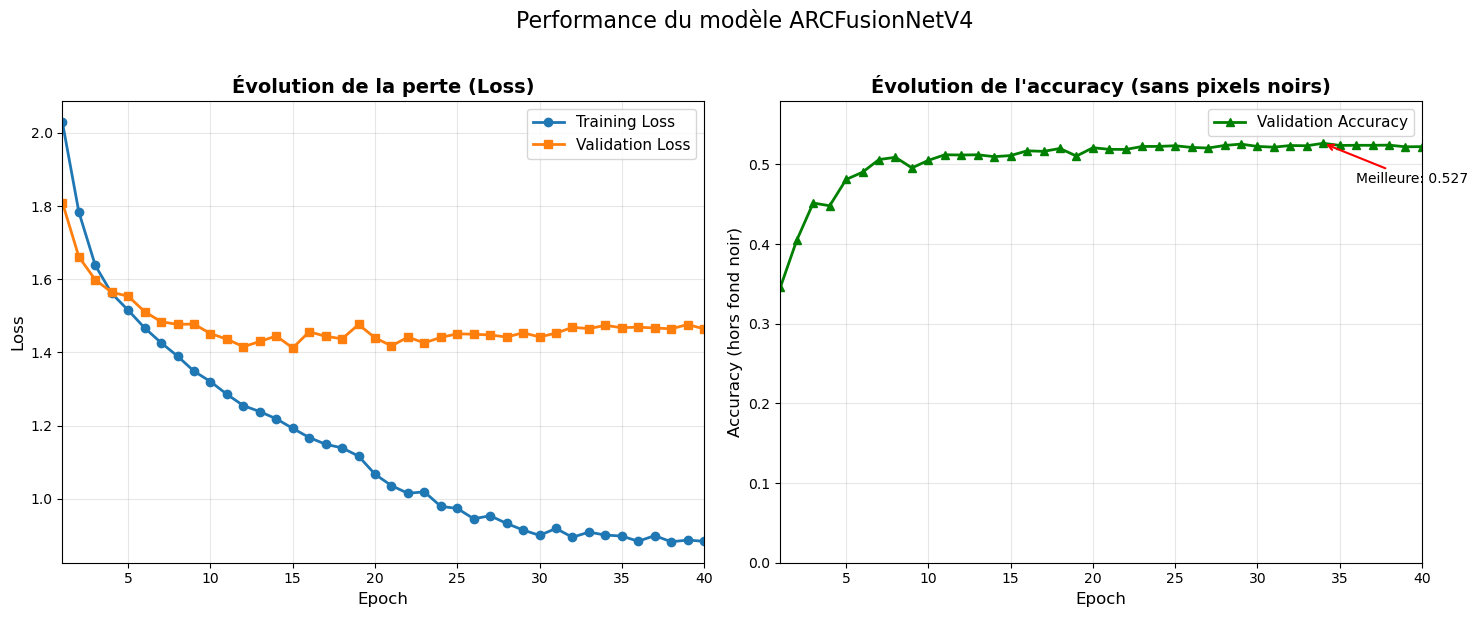


=== Résumé de l'entraînement ===
Nombre d'époques: 40
Perte finale (entraînement): 0.8837
Perte finale (validation): 1.4645
Meilleure accuracy (validation): 0.5266
Accuracy finale (validation): 0.5224


In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graph 1: Evolution of Loss
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, label='Training Loss', marker='o', linewidth=2)
ax1.plot(epochs, val_losses, label='Validation Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Évolution de la perte (Loss)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, len(train_losses))

# Graph 2: Evolution of Accuracy
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', marker='^', 
         color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (hors fond noir)', fontsize=12)
ax2.set_title("Évolution de l'accuracy (sans pixels noirs)", fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, len(val_accuracies))
ax2.set_ylim(0, max(val_accuracies) * 1.1 if val_accuracies else 1.0)

# Add best accuracy annotation
if val_accuracies:
    best_idx = np.argmax(val_accuracies)
    best_acc = val_accuracies[best_idx]
    best_epoch = epochs[best_idx]
    ax2.annotate(f'Meilleure: {best_acc:.3f}', 
                xy=(best_epoch, best_acc),
                xytext=(best_epoch + 2, best_acc - 0.05),
                fontsize=10,
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

# Overall title
fig.suptitle('Performance du modèle ARCFusionNetV4', fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()
plt.savefig('training_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Résumé de l'entraînement ===")
print(f"Nombre d'époques: {len(train_losses)}")
print(f"Perte finale (entraînement): {train_losses[-1]:.4f}")
print(f"Perte finale (validation): {val_losses[-1]:.4f}")
if val_accuracies:
    print(f"Meilleure accuracy (validation): {max(val_accuracies):.4f}")
    print(f"Accuracy finale (validation): {val_accuracies[-1]:.4f}")

In [109]:
def select_random_tasks(n_tasks=6):
    """Select n_tasks randomly from training and evaluation sets"""
    all_tasks = []
    
    # Add training tasks
    for task_id in training_data:
        if task_id in training_solutions:
            all_tasks.append(('training', task_id))
    
    # Add evaluation tasks
    for task_id in eval_data:
        if task_id in eval_solutions:
            all_tasks.append(('evaluation', task_id))
    
    # Ensure we have enough tasks
    if len(all_tasks) < n_tasks:
        n_tasks = len(all_tasks)
    
    selected = random.sample(all_tasks, n_tasks)
    return selected

# Utility functions
def preprocess_input(grid, target_size=30):
    """Convert grid to tensor format"""
    grid = np.array(grid)
    h, w = grid.shape
    
    # One-hot encoding
    tensor = torch.tensor(grid, dtype=torch.long)
    onehot = F.one_hot(tensor, num_classes=10).permute(2, 0, 1).float()
    
    # Padding
    pad_h = target_size - h
    pad_w = target_size - w
    padded = F.pad(onehot, (0, pad_w, 0, pad_h))
    
    return padded.unsqueeze(0).to(device)

def predict_task(model, task_info):
    """Generate predictions for a single task"""
    dataset_type, task_id = task_info
    
    if dataset_type == 'training':
        task = training_data[task_id]
        solutions = training_solutions[task_id]
    else:
        task = eval_data[task_id]
        solutions = eval_solutions[task_id]
    
    predictions = []
    expected_outputs = []
    
    # Process test cases
    test_inputs = task.get('test', [])
    test_outputs = solutions
    
    for test_input, expected in zip(test_inputs, test_outputs):
        input_grid = test_input['input']
        
        # Generate prediction
        input_tensor = preprocess_input(input_grid)
        with torch.no_grad():
            pred = model(input_tensor)
        
        pred_grid = pred.squeeze(0).argmax(0).cpu().numpy()
        predictions.append(pred_grid.tolist())
        expected_outputs.append(expected)
    
    return predictions, expected_outputs

def evaluate_predictions(predictions, expected_outputs):
    """Calculate accuracy excluding background pixels"""
    total_pixels = 0
    correct_pixels = 0
    
    for pred, expected in zip(predictions, expected_outputs):
        pred = np.array(pred)
        expected = np.array(expected)
        
        # Recadre la prédiction à la taille réelle de la sortie attendue
        h, w = expected.shape
        pred_cropped = pred[:h, :w]
        
        # Exclude background (0) pixels
        mask = expected != 0
        correct_pixels += np.sum(pred_cropped[mask] == expected[mask])
        total_pixels += np.sum(mask)
    
    accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0
    return accuracy

def visualize_task_results(task_info, predictions, expected, accuracy):
    """Create visualization for task results"""
    dataset_type, task_id = task_info
    
    fig, axes = plt.subplots(2, len(predictions), figsize=(15, 6))
    fig.suptitle(f"{dataset_type.title()} Task {task_id} - Accuracy: {accuracy:.3f}")
    
    for i, (pred, exp) in enumerate(zip(predictions, expected)):
        if len(predictions) == 1:
            ax_pred = axes[0]
            ax_exp = axes[1]
        else:
            ax_pred = axes[0, i] if len(predictions) > 1 else axes[0]
            ax_exp = axes[1, i] if len(predictions) > 1 else axes[1]
        
        ax_pred.imshow(pred, cmap='tab10', vmin=0, vmax=9)
        ax_pred.set_title(f"Prediction {i+1}")
        ax_pred.axis('off')
        
        ax_exp.imshow(exp, cmap='tab10', vmin=0, vmax=9)
        ax_exp.set_title(f"Expected {i+1}")
        ax_exp.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'test_results_{task_id}.png', dpi=150, bbox_inches='tight')
    plt.close()

def run_prediction_test():
    """Main function to test predictions on 6 random tasks"""
    print("=" * 60)
    print("TEST DE PRÉDICTIONS SUR SIX TÂCHES AU HASARD")
    print("=" * 60)
    
    # Load model
    try:
        model = ARCConvNet()
        model.load_state_dict(torch.load('../notebooks/arc_convnet.pth', map_location=device))
        model.eval()
        print("Model loaded successfully")
    except:
        print("Using untrained model")
        model = ARCConvNet()
        model.eval()
    
    # Select random tasks
    selected_tasks = select_random_tasks(6)
    print(f"\nSelected {len(selected_tasks)} tasks:")
    
    results = []
    
    for i, task_info in enumerate(selected_tasks, 1):
        print(f"\n{i}. Testing {task_info[0]} task: {task_info[1]}")
        
        # Generate predictions
        predictions, expected_outputs = predict_task(model, task_info)
        
        # Evaluate
        accuracy = evaluate_predictions(predictions, expected_outputs)
        
        results.append({
            'task_id': task_info[1],
            'dataset': task_info[0],
            'accuracy': accuracy,
            'predictions': predictions,
            'expected': expected_outputs,
            'n_test_cases': len(predictions)
        })
        
        print(f"   Accuracy: {accuracy:.3f} ({len(predictions)} test cases)")
        
        # Visualize results
        visualize_task_results(task_info, predictions, expected_outputs, accuracy)
    
    # Summary
    print("\n" + "=" * 60)
    print("RÉSUMÉ DES RÉSULTATS")
    print("=" * 60)
    
    accuracies = [r['accuracy'] for r in results]
    avg_accuracy = np.mean(accuracies)
    
    print(f"Average accuracy across all tasks: {avg_accuracy:.3f}")
    print(f"Best accuracy: {max(accuracies):.3f}")
    print(f"Worst accuracy: {min(accuracies):.3f}")
    
    for r in results:
        print(f"{r['dataset']} - {r['task_id']}: {r['accuracy']:.3f}")
    
    return results

if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Run the test
    test_results = run_prediction_test()

TEST DE PRÉDICTIONS SUR SIX TÂCHES AU HASARD
Model loaded successfully

Selected 6 tasks:

1. Testing training task: 3f23242b
   Accuracy: 0.031 (1 test cases)

2. Testing training task: 14754a24
   Accuracy: 0.840 (1 test cases)

3. Testing training task: 9565186b
   Accuracy: 0.111 (1 test cases)

4. Testing training task: 85c4e7cd
   Accuracy: 0.143 (1 test cases)

5. Testing training task: 7b6016b9
   Accuracy: 0.213 (1 test cases)

6. Testing training task: 4e7e0eb9
   Accuracy: 0.390 (2 test cases)

RÉSUMÉ DES RÉSULTATS
Average accuracy across all tasks: 0.288
Best accuracy: 0.840
Worst accuracy: 0.031
training - 3f23242b: 0.031
training - 14754a24: 0.840
training - 9565186b: 0.111
training - 85c4e7cd: 0.143
training - 7b6016b9: 0.213
training - 4e7e0eb9: 0.390


In [124]:
class ARCFusionNetV5(nn.Module):
    def __init__(self, num_classes=10, in_channels=10, feature_dim=20):
        super().__init__()
        self.num_classes = num_classes

        # Module spatial
        self.spatial_transformer = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Module de transformation spatiale apprise
        self.attention = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Branche features symboliques améliorée
        self.dense = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )

        # Fusion avec capacité augmentée
        self.fusion = nn.Sequential(
            nn.Linear(128*7*7 + 128, 2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, num_classes * 30 * 30),
        )

    def forward(self, x_img, x_feat):
        # Transformation spatiale
        spatial_feat = self.spatial_transformer(x_img)
        attention_map = self.attention(spatial_feat)
        attented = spatial_feat * attention_map
        img_feat = attented.view(attented.size(0), -1)

        # Features symboliques
        feat_feat = self.dense(x_feat)

        # Fusion
        fusion = torch.cat([img_feat, feat_feat], dim=1)
        out = self.fusion(fusion)
        return out.view(-1, self.num_classes, 30, 30)

In [126]:
def extract_symbolic_features(input, output):
    input, output = np.array(input), np.array(output)

    # Mesures de connectivité
    labeled_in = label(input != 0)[0]
    labeled_out = label(output != 0)[0]

    # Nouveaux Features
    connectivity_diff = abs(labeled_in.max() - labeled_out.max())
    centroid_dist = 0
    if labeled_in.max() > 0 and labeled_out.max() > 0:
        centroid_in = [prop.centroid for prop in regionprops(labeled_in)]
        centroid_out = [prop.centroid for prop in regionprops(labeled_out)]
        centroid_dist = np.mean([np.linalg.norm(np.array(c_in) - np.array(c_out))
                                 for c_in, c_out in zip(centroid_in, centroid_out)])
        
    # Features existants + nouveaux
    return [
        connectivity_diff,
        centroid_dist,
        np.mean(input),
        np.mean(output),
        np.std(input),
        np.std(output),
    ]

In [127]:
# Fonction d'augmentation géométrique corrigée
def apply_geometric_augmentation(input_grid, output_grid):
    """Version robuste qui garantit des copies contiguës"""
    choice = random.randint(0, 7)
        
    # Toujours faire une copie explicite !
    input_grid = np.array(input_grid, copy=True)
    output_grid = np.array(output_grid, copy=True)
        
    if choice == 0:
        return input_grid, output_grid
    elif choice == 1:
        return np.rot90(input_grid, 1), np.rot90(output_grid, 1)
    elif choice == 2:
        return np.rot90(input_grid, 2), np.rot90(output_grid, 2)
    elif choice == 3:
        return np.rot90(input_grid, 3), np.rot90(output_grid, 3)
    elif choice == 4:
        return np.fliplr(input_grid), np.fliplr(output_grid)
    elif choice == 5:
        return np.flipud(input_grid), np.flipud(output_grid)
    elif choice == 6:
        return np.rot90(np.fliplr(input_grid), 1), np.rot90(np.fliplr(output_grid), 1)
    else:  # choice == 7
        return np.rot90(np.flipud(input_grid)), np.rot90(np.flipud(output_grid))

In [129]:
# Nouvelle fonction de perte avec focal_loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1.0 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()
    
# Configuration d'entraînement révisée
model = ARCFusionNetV5().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
criterion = FocalLoss()

# Fonction de conversion robuste
def to_tensor_onehot_grids(grids, num_classes=10, target_size=30):
    tensors = []
    for grid in grids:
        # Convertir en tableau numpy et s'assurer d'avoir des strides positifs
        grid_np = np.array(grid)
        if not grid_np.flags.contiguous:
            grid_np = np.ascontiguousarray(grid_np)
        
        h, w = grid_np.shape
        grid_tensor = torch.tensor(grid_np, dtype=torch.long)
        onehot = torch.nn.functional.one_hot(grid_tensor, num_classes=num_classes)
        onehot = onehot.permute(2, 0, 1).float()
        padding = (0, target_size - w, 0, target_size - h)
        onehot_padded = torch.nn.functional.pad(onehot, padding)
        tensors.append(onehot_padded)
    return torch.stack(tensors)

from concurrent.futures import ThreadPoolExecutor

def augment_batch(xb_np, yb_np):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(apply_geometric_augmentation, xb_np, yb_np))
    return zip(*results)

# Fonction pour convertir un tenseur one-hot en grille numpy
def tensor_to_grid(tensor):
    """Convertit un tenseur one-hot (C, H, W) en grille 2D d'indices de classe"""
    return tensor.argmax(0).cpu().numpy()

# Pré-calcul des transformations pour les réutiliser
transformation_cache = {}

def apply_cached_augmentation(input_grid, output_grid):
    grid_hash = hash(input_grid.tobytes() + output_grid.tobytes())
    if grid_hash not in transformation_cache:
        transformation_cache[grid_hash] = apply_geometric_augmentation(input_grid, output_grid)
    return transformation_cache[grid_hash]

# Boucle d'entraînement optimisée
for epoch in range(100):
    model.train()
    train_loss = 0
    for batch_idx, (xb, xf, yb) in enumerate(train_loader):
        xb, xf, yb = xb.to(device), xf.to(device), yb.to(device)
        
        # Conversion directe sans passer par numpy
        with torch.no_grad():
            # Convertir les tenseurs one-hot en indices de classe
            xb_indices = xb.argmax(1).cpu().numpy()
            yb_indices = yb.argmax(1).cpu().numpy()
            
            # Augmentation
            xb_aug, yb_aug = [], []
            for i in range(len(xb_indices)):
                xi_aug, yi_aug = apply_geometric_augmentation(xb_indices[i], yb_indices[i])
                xb_aug.append(xi_aug)
                yb_aug.append(yi_aug)
            
            # Conversion en tenseurs
            xb_tensor = to_tensor_onehot_grids(xb_aug, num_classes=model.num_classes)
            yb_tensor = to_tensor_onehot_grids(yb_aug, num_classes=model.num_classes)
        
        xb_tensor, yb_tensor = xb_tensor.to(device), yb_tensor.to(device)
        
        # Forward pass
        preds = model(xb_tensor, xf)
        loss = criterion(preds, yb_tensor.argmax(1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)

print(f"Taille du batch: {xb.size(0)}")
print(f"Forme de xi avant augmentation: {xb_indices[i].shape}")
print(f"Forme de xi après augmentation: {xi_aug.shape}")

Taille du batch: 30
Forme de xi avant augmentation: (30, 30)
Forme de xi après augmentation: (30, 30)


In [131]:
# Nouvelle tentative avec Monitoring de l'accuracy 
# Correction de ArcFusionNetV5
class ARCFusionNetV5(nn.Module):
    def __init__(self, num_classes=10, in_channels=10, feature_dim=20):
        super().__init__()
        self.num_classes = num_classes
        
        # Branche image (CNN)
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=7, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15
            
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Flatten()
        )
        
        # Calcul dynamique de la dimension de sortie du CNN
        self.cnn_out_dim = self._get_cnn_output_dim(in_channels)
        
        # Branche features symboliques
        self.dense = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(self.cnn_out_dim + 128, 2048),  # 128 vient de la branche dense
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, num_classes * 30 * 30)
        )
    
    def _get_cnn_output_dim(self, in_channels):
        """Calcule dynamiquement la dimension de sortie du CNN"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, 30, 30)
            dummy_output = self.cnn(dummy_input)
            return dummy_output.shape[1]
    
    def forward(self, x_img, x_feat):
        # Transformation spatiale
        img_feat = self.cnn(x_img)
        
        # Features symboliques
        feat_feat = self.dense(x_feat)
        
        # Vérification des dimensions
        if img_feat.size(0) != feat_feat.size(0):
            raise ValueError(f"Batch size mismatch: CNN {img_feat.size(0)} vs Features {feat_feat.size(0)}")
        
        # Fusion
        fusion = torch.cat([img_feat, feat_feat], dim=1)
        out = self.fusion(fusion)
        return out.view(-1, self.num_classes, 30, 30)

In [136]:
# Initialisation
best_val_acc = 0.0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(100):
    # ENTRAÎNEMENT
    model.train()
    train_loss = 0.0
    
    for xb, xf, yb in train_loader:
        xb, xf, yb = xb.to(device), xf.to(device), yb.to(device)
        
        preds = model(xb, xf)
        loss = criterion(preds, yb.argmax(1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for xb, xf, yb in val_loader:
            xb, xf, yb = xb.to(device), xf.to(device), yb.to(device)
            
            preds = model(xb, xf)
            val_loss += criterion(preds, yb.argmax(1)).item()
            val_acc += accuracy_no_black(preds, yb)
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # LOGGING
    print(f"Epoch: {epoch+1:03d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # SAUVEGARDE
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f">>> Meilleur modèle sauvegardé (Accuracy: {best_val_acc:.4f})")
    
    # EARLY STOPPING
    if (epoch > 10) and (val_acc < best_val_acc - 0.05):
        print("Early stopping déclenché")
        break

# Chargement final du meilleur modèle
model.load_state_dict(torch.load('best_model.pth'))
print(f"\nMeilleure accuracy finale: {best_val_acc:.4f}")

Epoch: 001 | Train Loss: 0.0389 | Val Loss: 0.0388 | Val Acc: 0.3901 | LR: 1.00e-04
>>> Meilleur modèle sauvegardé (Accuracy: 0.3901)
Epoch: 002 | Train Loss: 0.0371 | Val Loss: 0.0386 | Val Acc: 0.3922 | LR: 1.00e-04
>>> Meilleur modèle sauvegardé (Accuracy: 0.3922)
Epoch: 003 | Train Loss: 0.0357 | Val Loss: 0.0382 | Val Acc: 0.4008 | LR: 1.00e-04
>>> Meilleur modèle sauvegardé (Accuracy: 0.4008)
Epoch: 004 | Train Loss: 0.0343 | Val Loss: 0.0381 | Val Acc: 0.3923 | LR: 1.00e-04
Epoch: 005 | Train Loss: 0.0331 | Val Loss: 0.0379 | Val Acc: 0.4192 | LR: 1.00e-04
>>> Meilleur modèle sauvegardé (Accuracy: 0.4192)
Epoch: 006 | Train Loss: 0.0321 | Val Loss: 0.0378 | Val Acc: 0.4139 | LR: 1.00e-04
Epoch: 007 | Train Loss: 0.0307 | Val Loss: 0.0380 | Val Acc: 0.4189 | LR: 1.00e-04
Epoch: 008 | Train Loss: 0.0297 | Val Loss: 0.0378 | Val Acc: 0.4261 | LR: 1.00e-04
>>> Meilleur modèle sauvegardé (Accuracy: 0.4261)
Epoch: 009 | Train Loss: 0.0288 | Val Loss: 0.0385 | Val Acc: 0.4119 | LR: 1.0

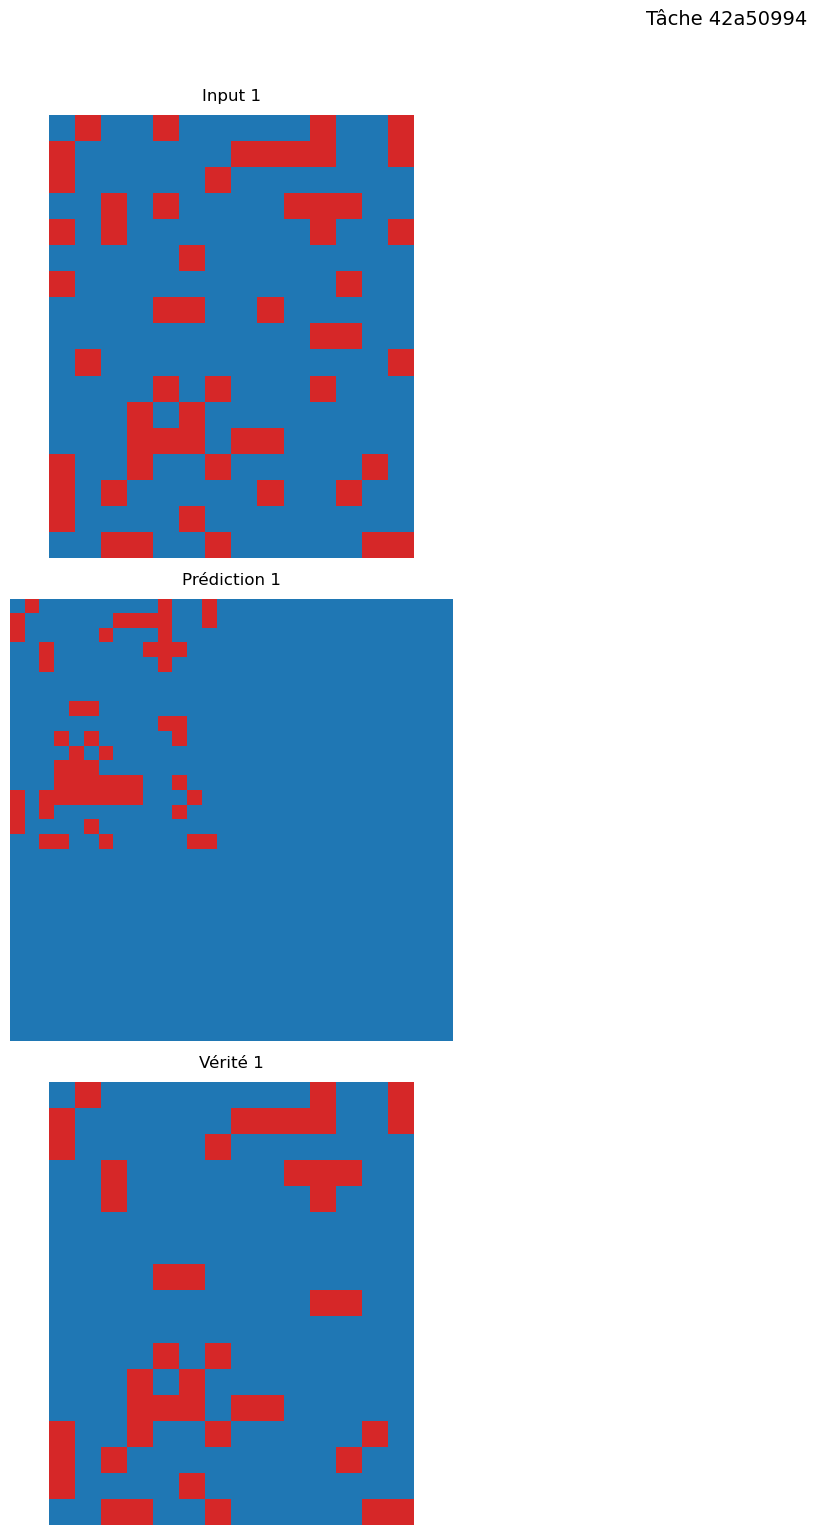


Accuracy pour la tâche 42a50994: 1.0000


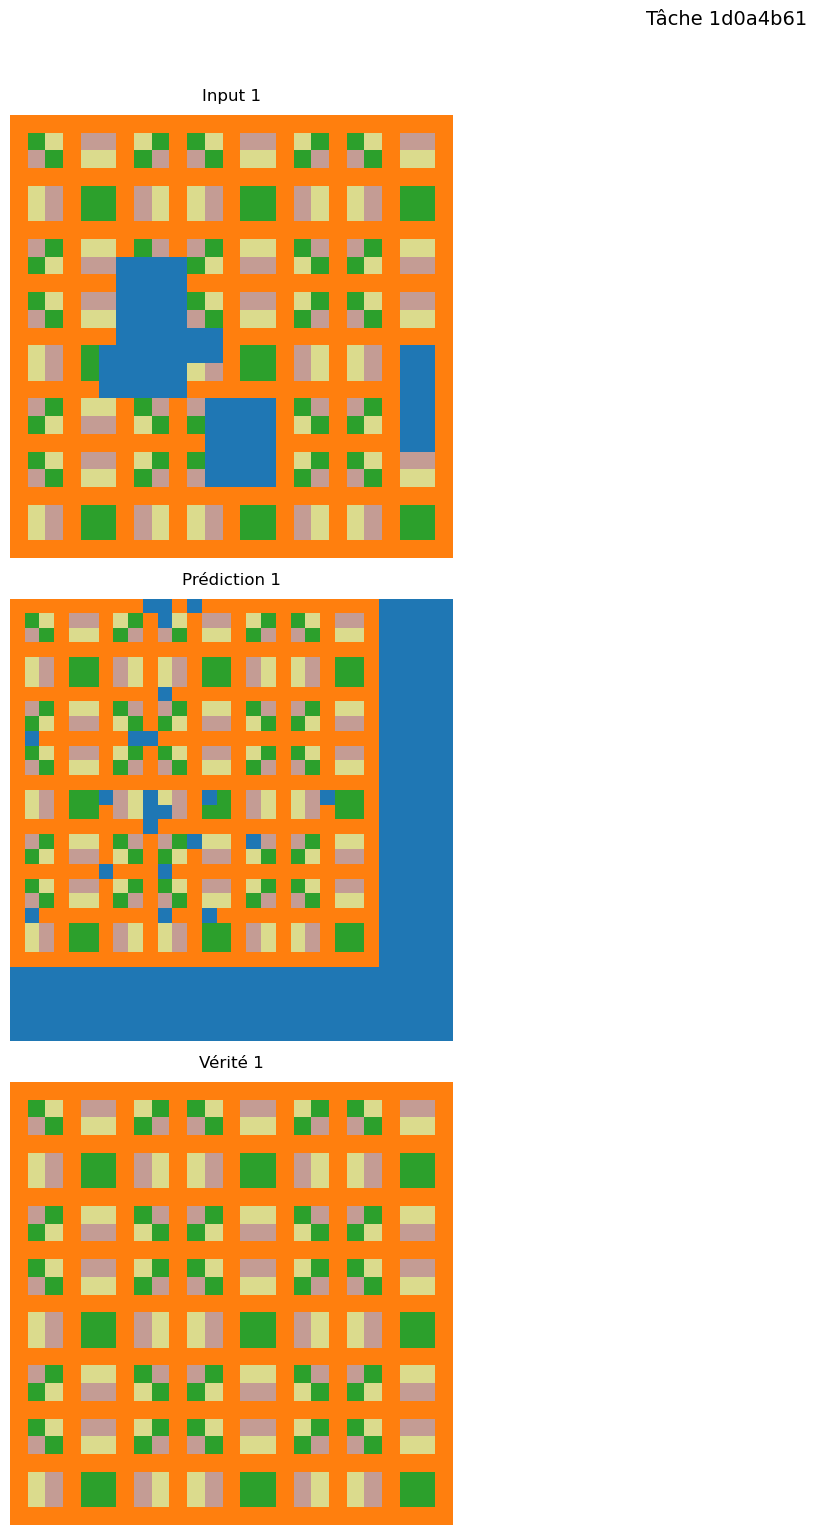


Accuracy pour la tâche 1d0a4b61: 0.9648


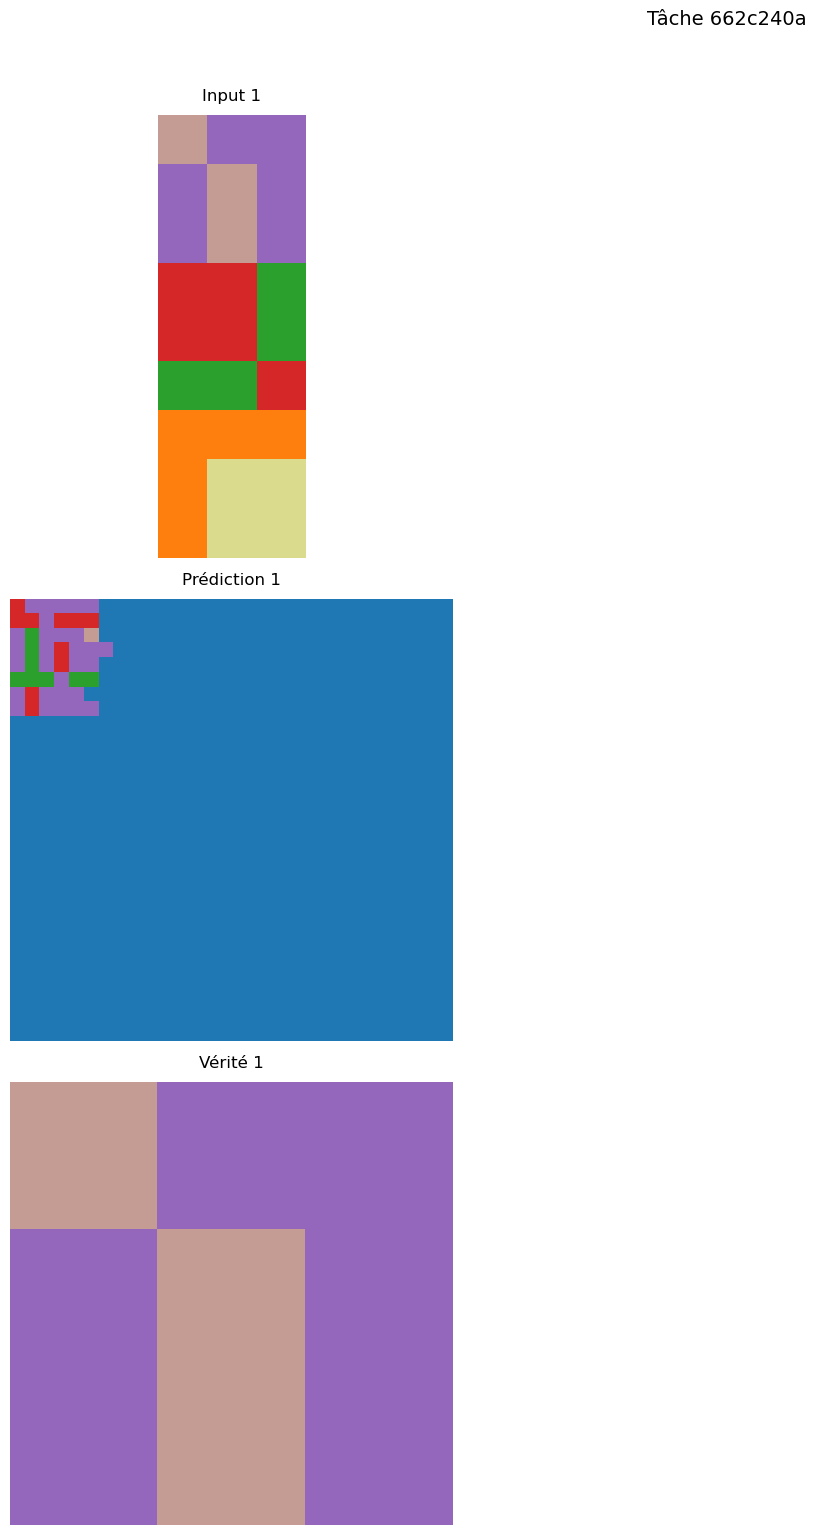


Accuracy pour la tâche 662c240a: 0.5556


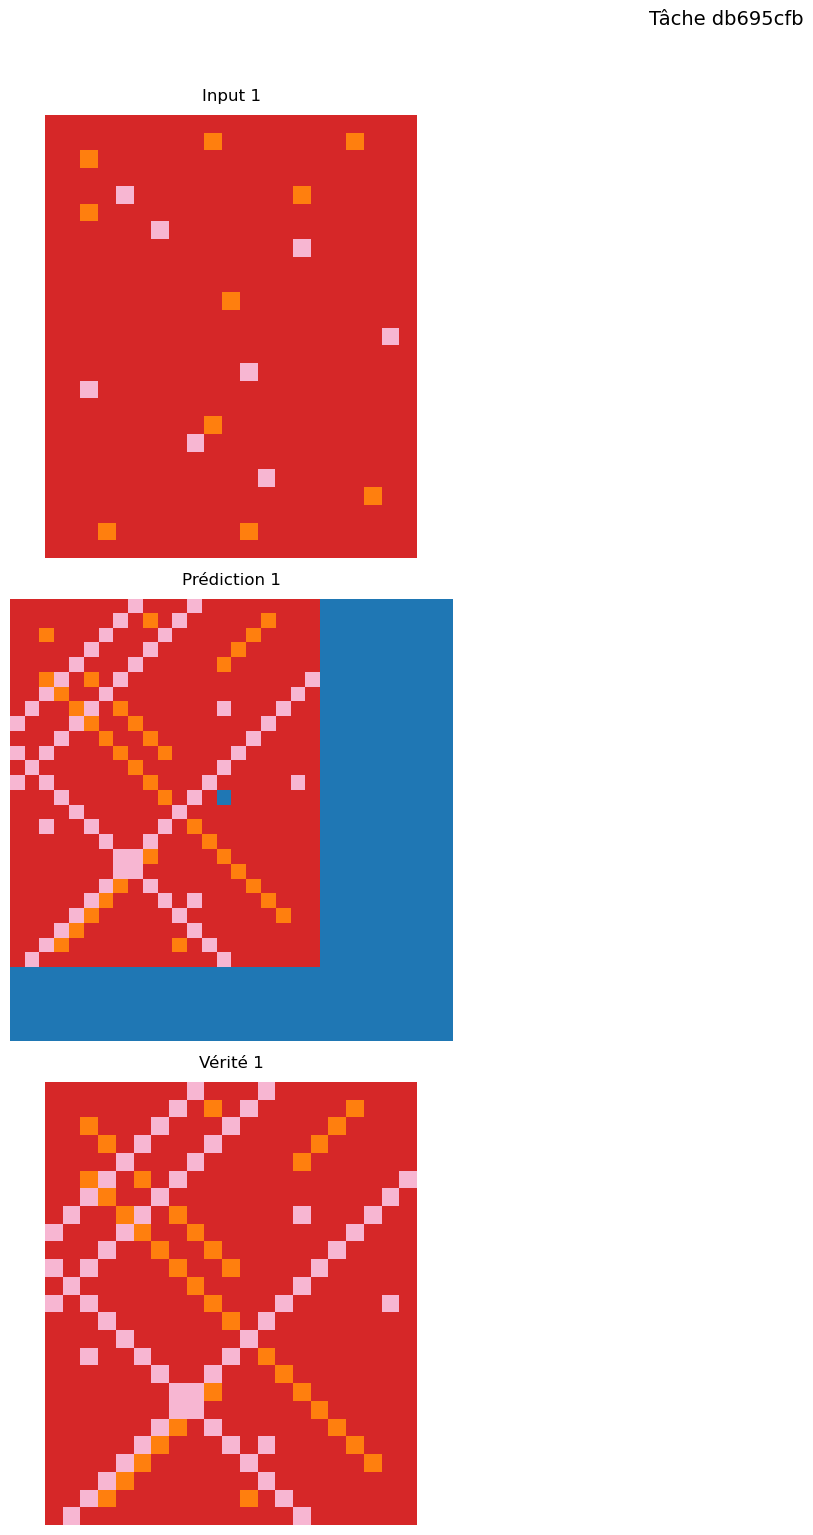


Accuracy pour la tâche db695cfb: 0.9962


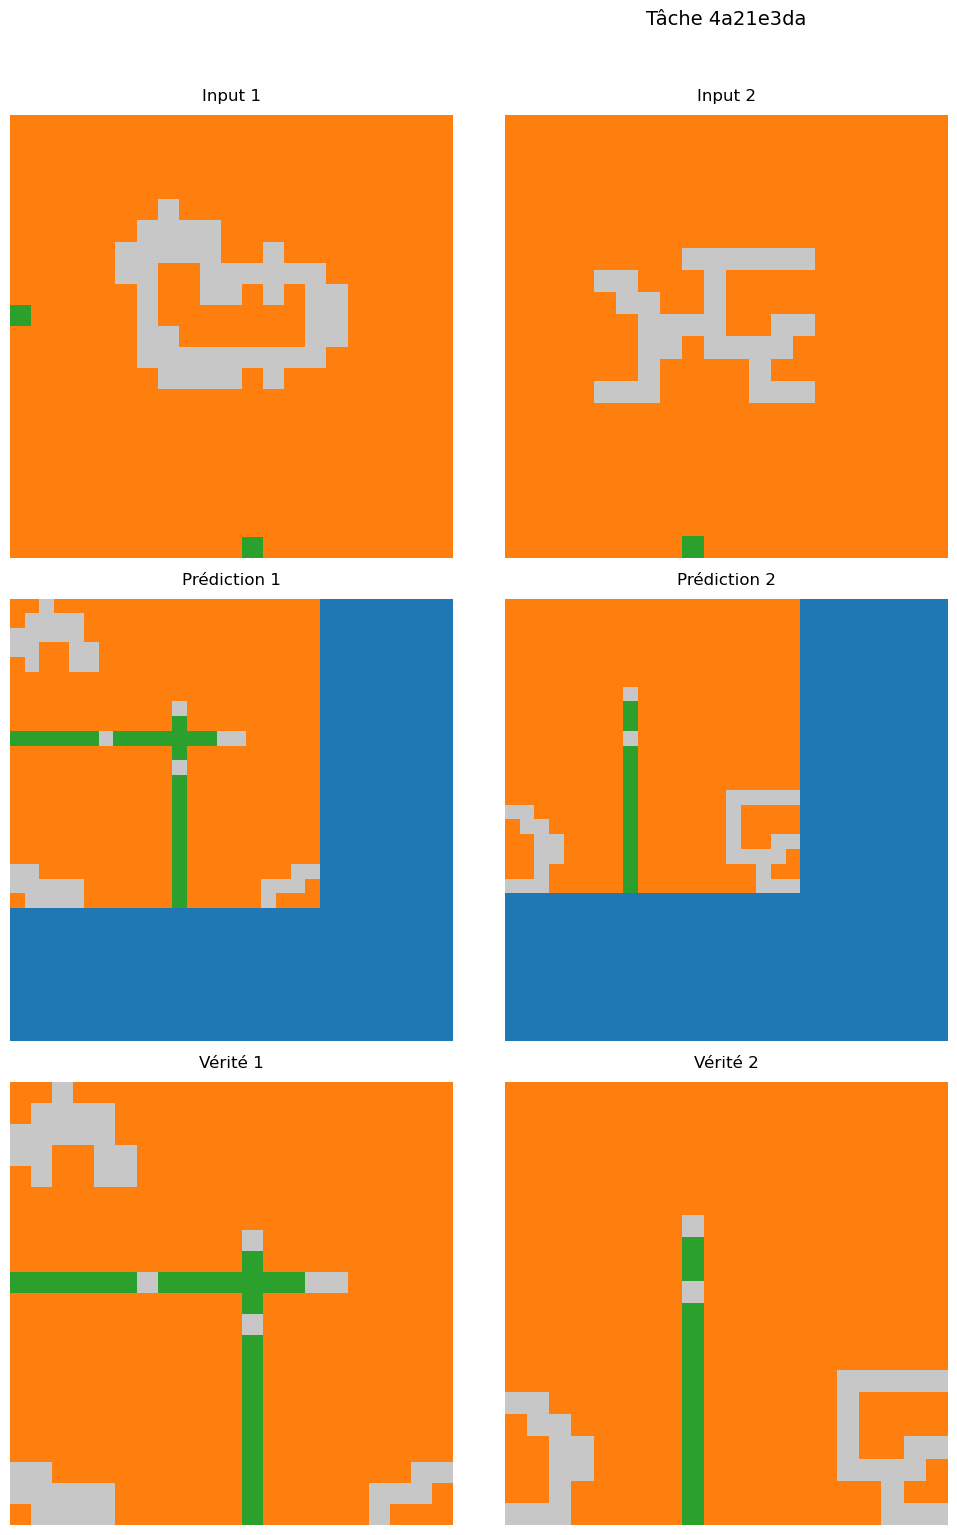


Accuracy pour la tâche 4a21e3da: 1.0000


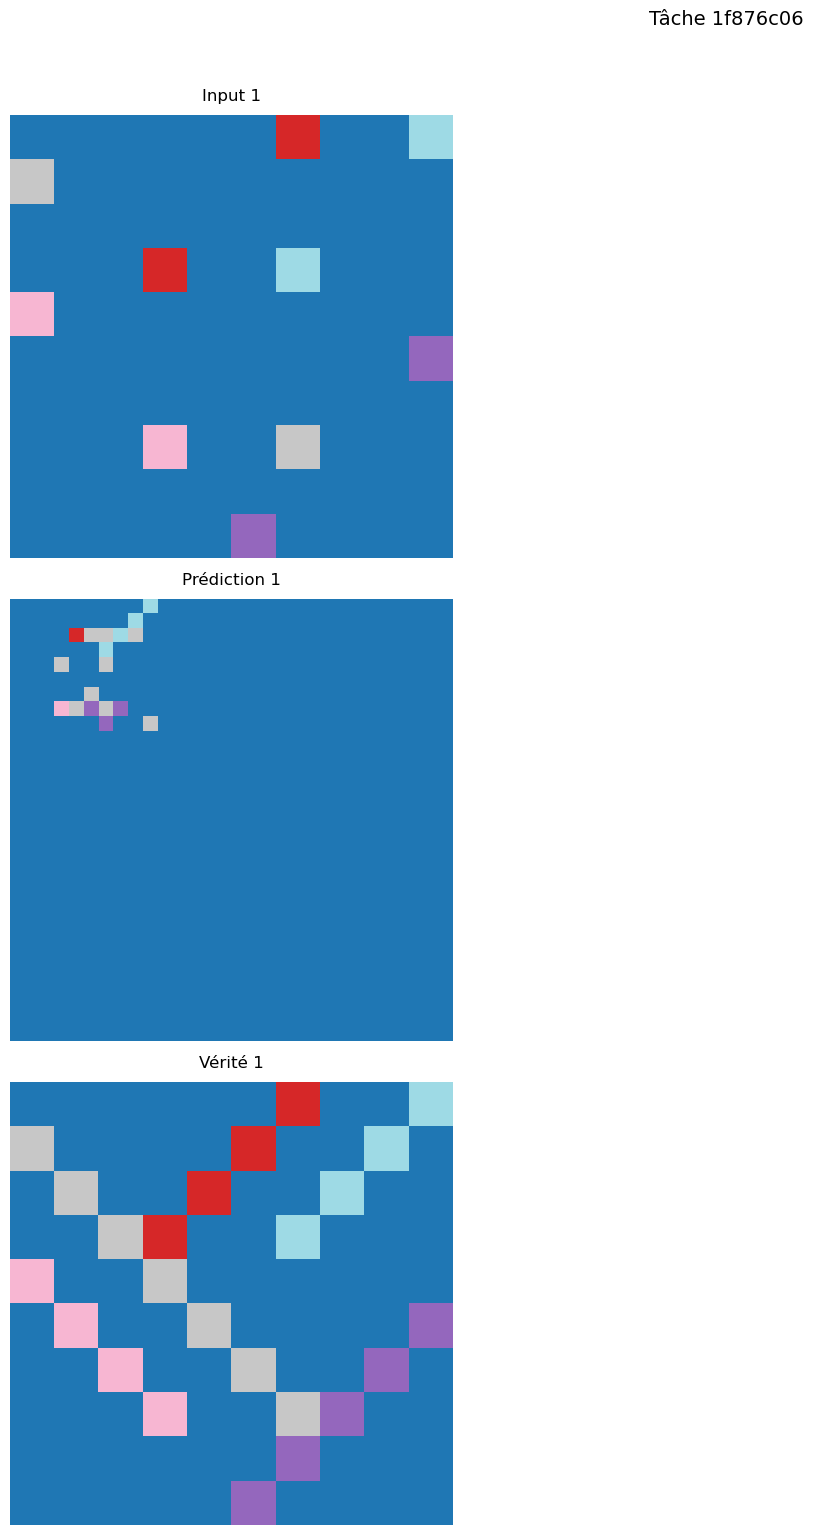


Accuracy pour la tâche 1f876c06: 0.4583


In [141]:
def visualize_task_predictions(model, task_ids, n_cols=3):
    """Version corrigée avec gestion robuste des layouts variables"""
    for task_id in task_ids:
        # Charger la tâche
        task = training_data.get(task_id) or eval_data.get(task_id)
        solutions = training_solutions.get(task_id) or eval_solutions.get(task_id)
        
        if not task or not solutions:
            print(f"\nTâche {task_id} non trouvée")
            continue
            
        test_cases = task.get('test', [])
        if not test_cases:
            print(f"\nPas de cas test pour la tâche {task_id}")
            continue
            
        n_cases = len(test_cases)
        # Calcul dynamique du nombre de lignes nécessaires
        n_rows = max(3, (n_cases + n_cols - 1) // n_cols)  # Au moins 3 lignes pour Input/Prédiction/Vérité
        
        plt.figure(figsize=(5*n_cols, 5*n_rows))
        plt.suptitle(f"Tâche {task_id}", y=1.02, fontsize=14)
        
        for i, test_case in enumerate(test_cases, 1):
            # --- Input ---
            plt.subplot(n_rows, n_cols, i)
            plt.imshow(test_case['input'], cmap='tab20', vmin=0, vmax=9)
            plt.title(f"Input {i}", pad=10)
            plt.axis('off')
            
            # Prédiction
            input_tensor = to_tensor_onehot_grids([test_case['input']]).to(device)
            with torch.no_grad():
                pred = model(input_tensor, torch.zeros(1, 20).to(device))  # Features factices
            pred_grid = pred.argmax(1).squeeze(0).cpu().numpy()
            
            plt.subplot(n_rows, n_cols, i + n_cols * (1 if n_cases <= n_cols else n_rows))
            plt.imshow(pred_grid, cmap='tab20', vmin=0, vmax=9)
            plt.title(f"Prédiction {i}", pad=10)
            plt.axis('off')
            
            # Vérité
            if i <= len(solutions):
                plt.subplot(n_rows, n_cols, i + n_cols * (2 if n_cases <= n_cols else 2*n_rows))
                plt.imshow(solutions[i-1], cmap='tab20', vmin=0, vmax=9)
                plt.title(f"Vérité {i}", pad=10)
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Calcul d'accuracy
        predictions = []
        for test_case in test_cases:
            input_tensor = to_tensor_onehot_grids([test_case['input']]).to(device)
            with torch.no_grad():
                pred = model(input_tensor, torch.zeros(1, 20).to(device))
            predictions.append(pred.argmax(1).squeeze(0).cpu().numpy().tolist())
        
        accuracy = evaluate_predictions(predictions, solutions[:len(test_cases)])
        print(f"\nAccuracy pour la tâche {task_id}: {accuracy:.4f}")
        print("="*50)

# Sélection et visualisation
random_tasks = select_random_tasks(6)
visualize_task_predictions(model, random_tasks)

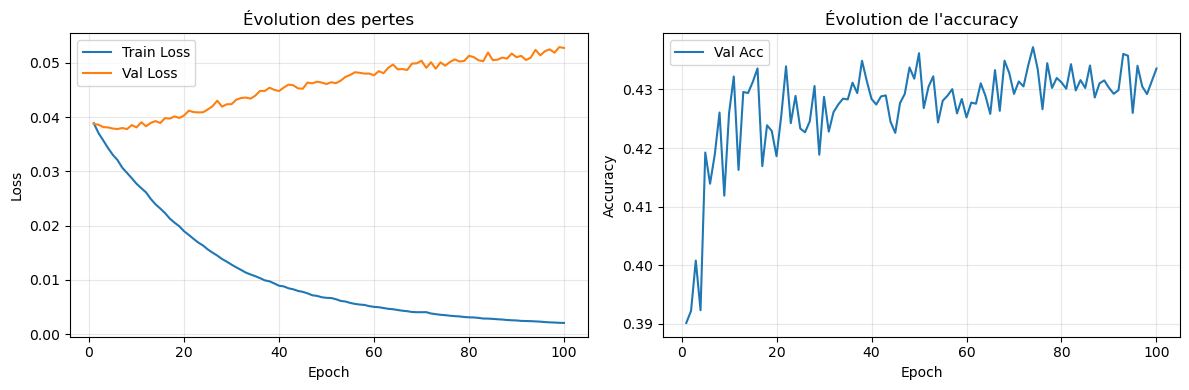

In [143]:
def visualize_task_predictions(model, task_ids):
    """Affiche, pour chaque tâche, une ligne par cas test : [Input | Prédiction | Vérité].
       Calcule aussi l'accuracy si la vérité est disponible.
    """
    model.eval()
    for task_id in task_ids:
        # --- Chargement tâche + solutions ---
        task = training_data.get(task_id) or eval_data.get(task_id)
        solutions = training_solutions.get(task_id) or eval_solutions.get(task_id)

        if not task or task.get('test') is None:
            print(f"Tâche {task_id} non trouvée ou sans cas test")
            continue

        test_cases = task['test']
        n_cases = len(test_cases)
        if n_cases == 0:
            print(f"Pas de cas test pour la tâche {task_id}")
            continue

        # --- Figure : n_cases lignes, 3 colonnes (input, pred, truth) ---
        fig = plt.figure(figsize=(12, 4*n_cases))
        fig.suptitle(f"Tâche {task_id}", y=0.995, fontsize=14)

        preds_list = []
        gts_list = []

        for i, test_case in enumerate(test_cases, 1):
            input_grid = test_case['input']
            input_tensor = to_tensor_onehot_grids([input_grid]).to(device)

            # Features (adapter si tu as de vraies features)
            dummy_features = torch.zeros(1, 20, device=device)

            with torch.no_grad():
                logits = model(input_tensor, dummy_features)
            pred_grid = logits.argmax(1).squeeze(0).detach().cpu().numpy()

            # Vérité (si disponible)
            true_output = None
            if solutions and len(solutions) >= i:
                true_output = solutions[i-1]
                gts_list.append(true_output)

            preds_list.append(pred_grid.tolist())

            # Col 1: Input 
            ax = plt.subplot(n_cases, 3, 3*(i-1) + 1)
            ax.imshow(input_grid, cmap='tab20', vmin=0, vmax=9)
            ax.set_title(f"Input {i}")
            ax.axis('off')

            # Col 2: Prediction
            ax = plt.subplot(n_cases, 3, 3*(i-1) + 2)
            ax.imshow(pred_grid, cmap='tab20', vmin=0, vmax=9)
            ax.set_title(f"Prédiction {i}")
            ax.axis('off')

            # Col 3: Vérité
            ax = plt.subplot(n_cases, 3, 3*(i-1) + 3)
            if true_output is not None:
                ax.imshow(true_output, cmap='tab20', vmin=0, vmax=9)
                ax.set_title(f"Vérité {i}")
            else:
                ax.text(0.5, 0.5, "Vérité indisponible", ha='center', va='center')
            ax.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

        # Accuracy (si ground truth complète)
        if solutions and len(solutions) >= n_cases:
            acc = evaluate_predictions(preds_list, solutions[:n_cases])
            print(f"Accuracy pour la tâche {task_id}: {acc:.4f}")
            print("="*50)

def plot_training_curves(train_losses, val_losses, val_accuracies):
    import matplotlib.pyplot as plt

    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(12,4))
    # Pertes
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Évolution des pertes")
    plt.legend(); plt.grid(True, alpha=0.3)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, val_accuracies, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Évolution de l'accuracy")
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()

plot_training_curves(train_losses, val_losses, val_accuracies)

